# Global Function in Healthcare Classification


In [1]:
#importing relevant libraries
import pandas as pd
import numpy as np
import string 
import nltk
import re
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, SimpleRNN, LSTM, Bidirectional, Dropout, GlobalAveragePooling1D
from keras.layers.convolutional import Conv1D, MaxPooling1D
import keras as keras
import nlpaug
import nlpaug.augmenter.word as naw
from itertools import repeat
import random
from pprint import pprint
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import pickle

**Implementing probability models (statistical models)**

In [2]:
#loading the file
global_func=pd.read_csv("globalfunc_long_withpuposecode.csv", engine="python")
global_func.head()

,YEAR,Donor.Name,Recipient.Name,Project.title,Purpose.Code,Short.Description,Long.Description,Value,category
0,2015,UNFPA,Mongolia,Output 04: HIV,16064,HIV,16064. Output 04: HIV. HIV. Mongolia -Ulaan Ba...,4.497275e-22,not_global_func
1,2013,World Health Organisation,"Bilateral, unspecified",CVCAGlobalLeadership and governance,12110,CVCA: GLOBALLEADERSHIP AND GOVERNANCE,12110. CVCAGlobalLeadership and governance. CV...,3.901426e-20,Health_Advocacy
2,2013,World Health Organisation,"Far East Asia, regional","ACFar East Asia, regionalReduction of risk fac...",12110,"AC: FAR EAST ASIA, REGIONALREDUCTION OF RISK F...","12110. ACFar East Asia, regionalReduction of r...",1.373741e-07,Health_Advocacy
3,2015,United States,Honduras,Maternal and Child Health,13020,MATERNAL AND CHILD HEALTH,13020. Maternal and Child Health. MATERNAL AND...,1.030151e-06,not_global_func
4,2015,UNFPA,Mali,Output 13: Analysis on population dynamics,13081,ANALYSIS ON POPULATION DYNAMICS,13081. Output 13: Analysis on population dynam...,1.559553e-06,Knowledge_Gen_Sharing


In [3]:
#Creating a new column by combining the short.description and Long.description column
#global_func["Long.Description"]=global_func["Short.Description"]+". "+ global_func["Long.Description"]

In [4]:
#dropping some columns
global_func=global_func.drop(["Donor.Name", "Recipient.Name", "Short.Description"], axis=1)

In [5]:
print(global_func.head())

print(global_func.shape)

   YEAR                                      Project.title  Purpose.Code  \
0  2015                                     Output 04: HIV         16064   
1  2013                CVCAGlobalLeadership and governance         12110   
2  2013  ACFar East Asia, regionalReduction of risk fac...         12110   
3  2015                          Maternal and Child Health         13020   
4  2015         Output 13: Analysis on population dynamics         13081   

                                    Long.Description         Value  \
0  16064. Output 04: HIV. HIV. Mongolia -Ulaan Ba...  4.497275e-22   
1  12110. CVCAGlobalLeadership and governance. CV...  3.901426e-20   
2  12110. ACFar East Asia, regionalReduction of r...  1.373741e-07   
3  13020. Maternal and Child Health. MATERNAL AND...  1.030151e-06   
4  13081. Output 13: Analysis on population dynam...  1.559553e-06   

                category  
0        not_global_func  
1        Health_Advocacy  
2        Health_Advocacy  
3        not_g

In [6]:
#renaming the category column to label
global_func=global_func.rename(columns={"category":"label", "Long.Description":"description"})

In [7]:
list(global_func.columns)

['YEAR', 'Project.title', 'Purpose.Code', 'description', 'Value', 'label']

In [8]:
global_func.head()

,YEAR,Project.title,Purpose.Code,description,Value,label
0,2015,Output 04: HIV,16064,16064. Output 04: HIV. HIV. Mongolia -Ulaan Ba...,4.497275e-22,not_global_func
1,2013,CVCAGlobalLeadership and governance,12110,12110. CVCAGlobalLeadership and governance. CV...,3.901426e-20,Health_Advocacy
2,2013,"ACFar East Asia, regionalReduction of risk fac...",12110,"12110. ACFar East Asia, regionalReduction of r...",1.373741e-07,Health_Advocacy
3,2015,Maternal and Child Health,13020,13020. Maternal and Child Health. MATERNAL AND...,1.030151e-06,not_global_func
4,2015,Output 13: Analysis on population dynamics,13081,13081. Output 13: Analysis on population dynam...,1.559553e-06,Knowledge_Gen_Sharing


In [9]:
global_func["label"]=global_func["label"].replace({'RD_Blueprint_Diseases_Pandemic_Flu':'Epidemic_Pandemic_Prep'})

In [10]:
# checking the unique categories in the label column. These categories were created combining the sub categories in the
#original dataset
label_cat=list(global_func.label.unique())
label_cat

['not_global_func',
 'Health_Advocacy',
 'Knowledge_Gen_Sharing',
 'Dev_Harmonization_Int_Reg',
 'Epidemic_Pandemic_Prep',
 'Control_Cross_Border_Disease',
 'Response_Unhealthy_Products',
 'Market_Shaping',
 'RD_New_Health_Tools',
 'Promotion_Aid_Effectiveness']

In [11]:
## removing many duplicate observation in not_global_func category
#creating a df with only not_global_function category
df=global_func[global_func["label"]=="not_global_func"]
df=df.reset_index(drop=True)
#droppping all the duplicate values
df_not_glob_func=df.drop_duplicates(subset=["description"]).reset_index(drop=True)
#subsetting the original data frame with categories other than health_advocacy
global_func=global_func[global_func["label"]!="not_global_func"].reset_index(drop=True)
#combining the to df
global_func=pd.concat([global_func, df_not_glob_func], axis=0).reset_index(drop=True)
#shuffling the data
global_func=shuffle(global_func).reset_index(drop=True)

global_func.head()

,YEAR,Project.title,Purpose.Code,description,Value,label
0,2015,Solomon Islands Health Sector Budget Support,12220,12220. Solomon Islands Health Sector Budget Su...,14.422510,not_global_func
1,2015,Investing towards Malaria Elimination,12262,12262. Investing towards Malaria Elimination. ...,7.379632,Control_Cross_Border_Disease
2,2015,Output 04: HIV,16064,16064. Output 04: HIV. HIV. Niger - Niamey. Ou...,0.000506,not_global_func
3,2017,Johns Hopkins University,13030,13030. Johns Hopkins University. JOHNS HOPKINS...,0.416566,Promotion_Aid_Effectiveness
4,2017,Children's Hospital & Research Center at Oakland,12250,12250. Children's Hospital & Research Center a...,0.052983,Knowledge_Gen_Sharing


In [12]:
global_func.shape

(13168, 6)

In [13]:
#Counting the number of each label categories
print("not_global_func:", len(global_func[global_func["label"]=="not_global_func"]))
print("Control_Cross_Border_Disease:", len(global_func[global_func["label"]=="Control_Cross_Border_Disease"]))
print("Health_Advocacy:", len(global_func[global_func["label"]=="Health_Advocacy"]))
print("Knowledge_Gen_Sharing:", len(global_func[global_func["label"]=="Knowledge_Gen_Sharing"]))
print("Dev_Harmonization_Int_Reg:", len(global_func[global_func["label"]=="Dev_Harmonization_Int_Reg"]))
print("Epidemic_Pandemic_Prep:", len(global_func[global_func["label"]=="Epidemic_Pandemic_Prep"]))
print("Response_Unhealthy_Products:", len(global_func[global_func["label"]=="Response_Unhealthy_Products"]))
print("Market_Shaping:", len(global_func[global_func["label"]=="Market_Shaping"]))
print("RD_New_Health_Tools:", len(global_func[global_func["label"]=="RD_New_Health_Tools"]))
#print("RD_Blueprint_Diseases_Pandemic_Flu:", len(global_func[global_func["label"]=="RD_Blueprint_Diseases_Pandemic_Flu"]))
print("Promotion_Aid_Effectiveness:", len(global_func[global_func["label"]=="Promotion_Aid_Effectiveness"]))

not_global_func: 2455
Control_Cross_Border_Disease: 1511
Health_Advocacy: 1045
Knowledge_Gen_Sharing: 3082
Dev_Harmonization_Int_Reg: 246
Epidemic_Pandemic_Prep: 1561
Response_Unhealthy_Products: 293
Market_Shaping: 1078
RD_New_Health_Tools: 1637
Promotion_Aid_Effectiveness: 260


In [14]:
#creating a list of all the category sizes
cat_size= [len(global_func[global_func["label"]=="not_global_func"]),
           len(global_func[global_func["label"]=="Health_Advocacy"]),
           len(global_func[global_func["label"]=="Knowledge_Gen_Sharing"]),          
         len(global_func[global_func["label"]=="Dev_Harmonization_Int_Reg"]),
           len(global_func[global_func["label"]=="Epidemic_Pandemic_Prep"]),
           len(global_func[global_func["label"]=="Control_Cross_Border_Disease"]),
          len(global_func[global_func["label"]=="Response_Unhealthy_Products"]),
           len(global_func[global_func["label"]=="Market_Shaping"]),
          len(global_func[global_func["label"]=="RD_New_Health_Tools"]),
           len(global_func[global_func["label"]=="Promotion_Aid_Effectiveness"]),
           #len(global_func[global_func["label"]=="RD_Blueprint_Diseases_Pandemic_Flu"])
          ]
cat_size

[2455, 1045, 3082, 246, 1561, 1511, 293, 1078, 1637, 260]

In [15]:
#creating a df of cat_size and cat_label

df={"label_cat":label_cat,
    "cat_size":cat_size
   }
df=pd.DataFrame(df)
df

,label_cat,cat_size
0,not_global_func,2455
1,Health_Advocacy,1045
2,Knowledge_Gen_Sharing,3082
3,Dev_Harmonization_Int_Reg,246
4,Epidemic_Pandemic_Prep,1561
5,Control_Cross_Border_Disease,1511
6,Response_Unhealthy_Products,293
7,Market_Shaping,1078
8,RD_New_Health_Tools,1637
9,Promotion_Aid_Effectiveness,260


In [16]:
#create a sorted dataframe
df_sorted=df.sort_values("cat_size")

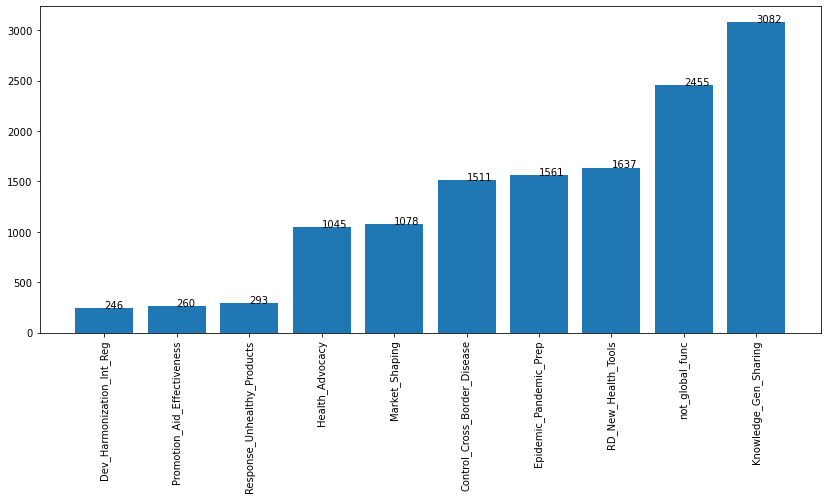

In [17]:
#plotting the distribution of categories. Creating column chart
#We can see there is  imbalance in the dataset
#plotting the observation cat
plt.figure(figsize=(14,6))
plt.bar(df_sorted["label_cat"], df_sorted["cat_size"])
plt.xticks(rotation=90)

for i, v in enumerate(df_sorted["cat_size"]):
    plt.text(i, v, str(v))

#we can see there is huge data imbalance between various categories. 
#Not a global function has a lot of data than the other categories
#This will be amjor problem when we run our model.
# There is very high probability that our model will become biased due to the large imbalance in the data

In [18]:
#percentage share of label 
print("Percent of not_global_func:{}%".format(round((len(global_func[global_func["label"]=="not_global_func"])/global_func.shape[0]), 3)*100))
print("Percent of Control_Cross_Border_Disease:{}%".format(round((len(global_func[global_func["label"]=="Control_Cross_Border_Disease"])/global_func.shape[0]), 3)*100))
print("Percent of Health_Advocacy:{}%".format(round((len(global_func[global_func["label"]=="Health_Advocacy"])/global_func.shape[0]), 4)*100))
print("Percent of Knowledge_Gen_Sharing:{}%".format(round((len(global_func[global_func["label"]=="Knowledge_Gen_Sharing"])/global_func.shape[0]),3)*100))
print("Percent of Dev_Harmonization_Int_Reg:{}%".format(round((len(global_func[global_func["label"]=="Dev_Harmonization_Int_Reg"])/global_func.shape[0]),3)*100))
print("Percent of Epidemic_Pandemic_Prep:{}%".format(round((len(global_func[global_func["label"]=="Epidemic_Pandemic_Prep"])/global_func.shape[0]),3)*100))
print("Percent of Response_Unhealthy_Products:{}%".format(round((len(global_func[global_func["label"]=="Response_Unhealthy_Products"])/global_func.shape[0]),4)*100))
print("Percent of Market_Shaping:{}%".format(round((len(global_func[global_func["label"]=="Market_Shaping"])/global_func.shape[0]),3)*100))
print("Percent of RD_New_Health_Tools:{}%".format(round((len(global_func[global_func["label"]=="RD_New_Health_Tools"])/global_func.shape[0]),3)*100))
#print("Percent of RD_Blueprint_Diseases_Pandemic_Flu:{}%".format(round((len(global_func[global_func["label"]=="RD_Blueprint_Diseases_Pandemic_Flu"])/global_func.shape[0]),3)*100))
print("Percent of Promotion_Aid_Effectiveness:{}%".format(round((len(global_func[global_func["label"]=="Promotion_Aid_Effectiveness"])/global_func.shape[0]),3)*100))


Percent of not_global_func:18.6%
Percent of Control_Cross_Border_Disease:11.5%
Percent of Health_Advocacy:7.9399999999999995%
Percent of Knowledge_Gen_Sharing:23.400000000000002%
Percent of Dev_Harmonization_Int_Reg:1.9%
Percent of Epidemic_Pandemic_Prep:11.899999999999999%
Percent of Response_Unhealthy_Products:2.23%
Percent of Market_Shaping:8.200000000000001%
Percent of RD_New_Health_Tools:12.4%
Percent of Promotion_Aid_Effectiveness:2.0%


In [19]:
#dropping Promotion_Aid_Effectiveness"  and "RD_Blueprint_Diseases_Pandemic_Flu" observation as these are very few in number
#global_func=global_func[(global_func["label"]!=("Promotion_Aid_Effectiveness"))]
#global_func=global_func[(global_func["label"]!=("RD_Blueprint_Diseases_Pandemic_Flu"))]
#global_func=global_func[(global_func["label"]!=("RD_New_Health_Tools"))]


In [20]:
global_func.label.unique()

array(['not_global_func', 'Control_Cross_Border_Disease',
       'Promotion_Aid_Effectiveness', 'Knowledge_Gen_Sharing',
       'Health_Advocacy', 'Market_Shaping', 'Epidemic_Pandemic_Prep',
       'RD_New_Health_Tools', 'Dev_Harmonization_Int_Reg',
       'Response_Unhealthy_Products'], dtype=object)

In [21]:
global_func.shape

(13168, 6)

##### Calculating 2017 total CGH funding

In [41]:
#Total CGH 2017
df_2017=global_func[global_func["YEAR"]==2017]

df_CGH_2017=df_2017[df_2017["label"]!="not_global_func"]

df_CGH_2017

,YEAR,Project.title,Purpose.Code,description,Value,label
3,2017,Johns Hopkins University,13030,13030. Johns Hopkins University. JOHNS HOPKINS...,0.416566,Promotion_Aid_Effectiveness
4,2017,Children's Hospital & Research Center at Oakland,12250,12250. Children's Hospital & Research Center a...,0.052983,Knowledge_Gen_Sharing
6,2017,Supporting the Fourth Global Symposium on Heal...,12110,12110. Supporting the Fourth Global Symposium ...,0.008455,Knowledge_Gen_Sharing
7,2017,The University of Warwick,12250,12250. The University of Warwick. THE UNIVERSI...,0.068000,Knowledge_Gen_Sharing
9,2017,Improving quality of maternal health care for ...,13020,13020. Improving quality of maternal health ca...,0.007900,Knowledge_Gen_Sharing
...,...,...,...,...,...,...
13153,2017,AIDS Vaccine Advocacy Coalition,13040,13040. AIDS Vaccine Advocacy Coalition. AIDS V...,0.903837,Market_Shaping
13155,2017,"Avenir Health, Inc.",13030,"13030. Avenir Health, Inc.. AVENIR HEALTH, INC...",0.005065,Knowledge_Gen_Sharing
13158,2017,Pandemic Influenza and Other Emerging Threats ...,12250,12250. Pandemic Influenza and Other Emerging T...,0.000410,Epidemic_Pandemic_Prep
13162,2017,The Aurum Institute NPC,12263,12263. The Aurum Institute NPC. THE AURUM INST...,0.500000,Knowledge_Gen_Sharing


In [42]:
df_CGH_2017["Value"].sum()

4409.058575764367

In [47]:
#Total CGH 2015
df_2015=global_func[global_func["YEAR"]==2015]

df_CGH_2015=df_2015[df_2015["label"]!="not_global_func"]

df_CGH_2015

,YEAR,Project.title,Purpose.Code,description,Value,label
1,2015,Investing towards Malaria Elimination,12262,12262. Investing towards Malaria Elimination. ...,7.379632,Control_Cross_Border_Disease
8,2015,"ACMiddle East, regionalLeadership and Governance",12110,"12110. ACMiddle East, regionalLeadership and G...",3.670489,Health_Advocacy
16,2015,Feasibility Study: Effectiveness of Public Hea...,12191,12191. Feasibility Study: Effectiveness of Pub...,0.013488,Knowledge_Gen_Sharing
19,2015,Duke University,13040,13040. Duke University. DUKE UNIVERSITY. to fa...,1.215839,RD_New_Health_Tools
22,2015,CDC: International Ebola Activities,12250,12250. CDC: International Ebola Activities. CD...,0.069187,Epidemic_Pandemic_Prep
...,...,...,...,...,...,...
13152,2015,U.S. Census Bureau Participating Agency Progra...,13030,13030. U.S. Census Bureau Participating Agency...,3.511814,Knowledge_Gen_Sharing
13156,2015,"CVCASouth & Central Asia, regionalLeadership a...",12110,"12110. CVCASouth & Central Asia, regionalLeade...",0.039168,Health_Advocacy
13157,2015,Regional Workshop to Prioritize and Coordinate...,12110,12110. Regional Workshop to Prioritize and Coo...,0.007166,Response_Unhealthy_Products
13161,2015,New vaccine support (NVS),12220,12220. New vaccine support (NVS). NEW VACCINE ...,0.821743,Control_Cross_Border_Disease


In [48]:
df_CGH_2015["Value"].sum()

4670.615864680396

In [49]:
#Total CGH 2013
df_2013=global_func[global_func["YEAR"]==2013]

df_CGH_2013=df_2013[df_2013["label"]!="not_global_func"]

df_CGH_2013

,YEAR,Project.title,Purpose.Code,description,Value,label
5,2013,"CVCAEurope, regionalKey stages of life includi...",12110,"12110. CVCAEurope, regionalKey stages of life ...",1.284838,Health_Advocacy
10,2013,New vaccine support (NVS),12220,12220. New vaccine support (NVS). NEW VACCINE ...,5.392000,Market_Shaping
11,2013,Ecohealth Emerging Infectious Diseases Researc...,12250,12250. Ecohealth Emerging Infectious Diseases ...,0.000104,Knowledge_Gen_Sharing
14,2013,New vaccine support (NVS),12220,12220. New vaccine support (NVS). NEW VACCINE ...,0.223940,Market_Shaping
23,2013,Quality Health Care Project (QHCP) - Other Pub...,12220,12220. Quality Health Care Project (QHCP) - Ot...,0.549825,Promotion_Aid_Effectiveness
...,...,...,...,...,...,...
13145,2013,Oregon Health & Science University,13040,13040. Oregon Health & Science University. ORE...,3.640566,RD_New_Health_Tools
13149,2013,"Avenir Health, Inc.",13030,"13030. Avenir Health, Inc.. AVENIR HEALTH, INC...",0.117092,Knowledge_Gen_Sharing
13150,2013,University of Pittsburgh,12182,12182. University of Pittsburgh. UNIVERSITY OF...,0.103629,RD_New_Health_Tools
13154,2013,Development Innovation Ventures - Maternal and...,13020,13020. Development Innovation Ventures - Mater...,0.636519,RD_New_Health_Tools


In [50]:
df_CGH_2013["Value"].sum()

3315.379535934601

#### Splitting data into train and test set

In [22]:
#len(global_func[global_func["YEAR"]==2015])

In [23]:
#len(global_func[global_func["YEAR"]==2013])

In [24]:
#len(global_func[global_func["YEAR"]==2017])

In [25]:
#train=global_func[global_func["YEAR"]!=2017]

In [26]:
#test=global_func[global_func["YEAR"]==2017]

In [27]:
#train

In [28]:
#splitting the data in 20% test and 80% train. 
#test data will only be used on the best selected final model. 
#train data will be used for k-fold cross validation to select best model

# X_train, X_test, y_train, y_test=train_test_split(global_func["description"], global_func["label"],
#                                                   test_size=0.2, shuffle=True)

train, test=train_test_split(global_func, test_size=0.2, shuffle=True)

In [29]:
train.reset_index(inplace=True, drop=True)
train=train.copy()
train.head()

,YEAR,Project.title,Purpose.Code,description,Value,label
0,2017,Assessing Zika transmission dynamics and mitig...,12182,12182. Assessing Zika transmission dynamics an...,0.031470,Epidemic_Pandemic_Prep
1,2017,HHS/CDC: RAPID RESPONSE TO EBOLA VIRAL DISEASE...,12250,12250. HHS/CDC: RAPID RESPONSE TO EBOLA VIRAL ...,0.643220,Epidemic_Pandemic_Prep
2,2015,Asian Vegetable Research & Development Center ...,13020,13020. Asian Vegetable Research & Development ...,0.515076,Response_Unhealthy_Products
3,2017,Enhanced Effective ICT,13040,13040. Enhanced Effective ICT. ENHANCED EFFECT...,0.000720,not_global_func
4,2017,"Avenir Health, Inc.",13030,"13030. Avenir Health, Inc.. AVENIR HEALTH, INC...",0.005065,Knowledge_Gen_Sharing


In [30]:
train.shape

(10534, 6)

In [31]:
train["label"].unique()

array(['Epidemic_Pandemic_Prep', 'Response_Unhealthy_Products',
       'not_global_func', 'Knowledge_Gen_Sharing', 'Market_Shaping',
       'Control_Cross_Border_Disease', 'RD_New_Health_Tools',
       'Health_Advocacy', 'Promotion_Aid_Effectiveness',
       'Dev_Harmonization_Int_Reg'], dtype=object)

In [32]:
test.reset_index(inplace=True, drop=True)
test.head()

,YEAR,Project.title,Purpose.Code,description,Value,label
0,2013,Projet de coopTration universitaire - Initiati...,12182,12182. Projet de coopTration universitaire - I...,0.073950,not_global_func
1,2013,New vaccine support (NVS),12220,12220. New vaccine support (NVS). NEW VACCINE ...,0.096651,Market_Shaping
2,2015,EDCTP2: EUROPEAN AND DEVELOPING COUNTRIES CLIN...,12182,12182. EDCTP2: EUROPEAN AND DEVELOPING COUNTRI...,3.040122,RD_New_Health_Tools
3,2017,Scientific cooperation with other countries (n...,12182,12182. Scientific cooperation with other count...,0.038746,Knowledge_Gen_Sharing
4,2015,INT/Fund of the United Nations International D...,13010,13010. INT/Fund of the United Nations Internat...,0.914221,Response_Unhealthy_Products


In [33]:
#creating a copy of the test dataframe as not doing this creates problem later (not sure why!)
test=test.copy()

In [34]:
test.head()

,YEAR,Project.title,Purpose.Code,description,Value,label
0,2013,Projet de coopTration universitaire - Initiati...,12182,12182. Projet de coopTration universitaire - I...,0.073950,not_global_func
1,2013,New vaccine support (NVS),12220,12220. New vaccine support (NVS). NEW VACCINE ...,0.096651,Market_Shaping
2,2015,EDCTP2: EUROPEAN AND DEVELOPING COUNTRIES CLIN...,12182,12182. EDCTP2: EUROPEAN AND DEVELOPING COUNTRI...,3.040122,RD_New_Health_Tools
3,2017,Scientific cooperation with other countries (n...,12182,12182. Scientific cooperation with other count...,0.038746,Knowledge_Gen_Sharing
4,2015,INT/Fund of the United Nations International D...,13010,13010. INT/Fund of the United Nations Internat...,0.914221,Response_Unhealthy_Products


In [35]:
test.shape

(2634, 6)

##### Creating synthetic text to manage the imbalance in different categories--replacing some words with their synonyms

**Note that we will only create synthetic text for training examples. We will not create synthetic text for test data.

In [36]:
# checking the unique categories in the label column. These categories were created combining the sub categories in the
#original dataset
label_cat=list(global_func.label.unique())
label_cat

['not_global_func',
 'Control_Cross_Border_Disease',
 'RD_New_Health_Tools',
 'Health_Advocacy',
 'Knowledge_Gen_Sharing',
 'Response_Unhealthy_Products',
 'Market_Shaping',
 'Epidemic_Pandemic_Prep',
 'Promotion_Aid_Effectiveness',
 'Dev_Harmonization_Int_Reg']

In [37]:
#observations in different classes
dict_list={}
for j in range(len(label_cat)):
    count=0
    for i in train["description"].index:
        if train["label"][i]==label_cat[j]:
            count +=1
    dict_list[label_cat[j]]=count
    #print("{}: {}".format(label_cat[j], count))
    
dict_list

{'not_global_func': 1971,
 'Control_Cross_Border_Disease': 1201,
 'RD_New_Health_Tools': 1307,
 'Health_Advocacy': 842,
 'Knowledge_Gen_Sharing': 2497,
 'Response_Unhealthy_Products': 233,
 'Market_Shaping': 854,
 'Epidemic_Pandemic_Prep': 1233,
 'Promotion_Aid_Effectiveness': 203,
 'Dev_Harmonization_Int_Reg': 193}

In [38]:
#sorting dictionary in descending order
dict_list=dict(sorted(dict_list.items(), key=lambda x:x[1], reverse=True))
dict_list

{'Knowledge_Gen_Sharing': 2497,
 'not_global_func': 1971,
 'RD_New_Health_Tools': 1307,
 'Epidemic_Pandemic_Prep': 1233,
 'Control_Cross_Border_Disease': 1201,
 'Market_Shaping': 854,
 'Health_Advocacy': 842,
 'Response_Unhealthy_Products': 233,
 'Promotion_Aid_Effectiveness': 203,
 'Dev_Harmonization_Int_Reg': 193}

In [39]:
#getting the list out of keys from dictionary
label_cat=list(dict_list.keys())
label_cat

['Knowledge_Gen_Sharing',
 'not_global_func',
 'RD_New_Health_Tools',
 'Epidemic_Pandemic_Prep',
 'Control_Cross_Border_Disease',
 'Market_Shaping',
 'Health_Advocacy',
 'Response_Unhealthy_Products',
 'Promotion_Aid_Effectiveness',
 'Dev_Harmonization_Int_Reg']

In [40]:
#list to store augmented text from training set
augmented_sentences=[]

#list to store augmented text labels from training set
augmented_sentences_labels=[]

#function to create synthetic text
def text_aug(label_cat): 
    
    #observations in different classes
    dict_list={}
    for j in range(len(label_cat)):
        count=0
        for i in train["description"].index:
            if train["label"][i]==label_cat[j]:
                count +=1
        dict_list[label_cat[j]]=count
    
    #initiating augmenter--replacing with 5 synonyms
    aug = naw.SynonymAug(aug_src='wordnet',aug_max=5)
       
    for j in range(1, len(label_cat)):
        class_list=[]
        aug_temp=[]
        aug_sent_temp=[]
        for i in train["description"].index:
            if train["label"][i]==label_cat[j]:
                #creating and appending augmented sentences
                aug_temp.append(aug.augment(train["description"][i], 
                                                       n=round(((sorted(list(dict_list.values()))[-1]-dict_list[label_cat[j]])/dict_list[label_cat[j]]))))  
                
        #unlisting the nested lists when: 
        #(round((sorted(list(dict_list.values()))[-1]-dict_list[label_cat[j]])/dict_list[label_cat[j]]))>1)
        if (round((sorted(list(dict_list.values()))[-1]-dict_list[label_cat[j]])/dict_list[label_cat[j]])>1):
            for k in range(len(aug_temp)):
                for m in range(round((sorted(list(dict_list.values()))[-1]-dict_list[label_cat[j]])/dict_list[label_cat[j]])):
                    class_list.append((aug_temp[k][m]))                        
        
        #unlisting the nested lists when: 
        #(round((sorted(list(dict_list.values()))[-1]-dict_list[label_cat[j]])/dict_list[label_cat[j]]))==0)
        elif(round((sorted(list(dict_list.values()))[-1]-dict_list[label_cat[j]])/dict_list[label_cat[j]])==0):            
            for q in range(len(aug_temp)):
                for r in range(round((sorted(list(dict_list.values()))[-1]-dict_list[label_cat[j]])/dict_list[label_cat[j]])+1):
                    class_list.append((aug_temp[q][r])) 
                    
        #unlisting the nested lists when: 
        #(round((sorted(list(dict_list.values()))[-1]-dict_list[label_cat[j]])/dict_list[label_cat[j]]))==1)
        else:
            for p in range(len(aug_temp)):
                class_list.append((aug_temp[p])) 
    
        #creating labels for the synthetic values
        aug_sent_temp.extend(repeat(label_cat[j],len(class_list)))
        
        #subsetting the synthetic sentences to be equal to the length of highest category
        if ((list(dict_list.values())[0]-(list(dict_list.values())[j]+len(class_list)))<0):
            text_needed=len(class_list)-abs(list(dict_list.values())[0]-(list(dict_list.values())[j]+len(class_list)))
            sample_text=random.sample(class_list, text_needed)
            sample_label=random.sample(aug_sent_temp, text_needed)
            augmented_sentences.extend(sample_text)
            augmented_sentences_labels.extend(sample_label)
        #if the length is smaller than the highest catgory then do nothing    
        else:
            augmented_sentences.extend(class_list)
            augmented_sentences_labels.extend(aug_sent_temp)    

In [41]:
#running the function sythetic text function
text_aug(label_cat)

In [42]:
#checking the augmented text created
augmented_sentences

['13010. National Endowment for Democracy Grant to Unspecified NGO. NATIONAL ENDOWMENT FOR DEMOCRACY GRANT TO UNSPECIFIED NGO. To encourage public discussion, transparency, and advocacy about Chinas family planning policies.  Research and reporting on the policies and practices of family planning agencies will be conducted, and legal assistance for victims and advocacy will be organized to advance respect for individual rights.',
 "13020. Government Technical Assistance Provider (GoTAP). GOVERNMENT TECHNICAL ASSISTANCE PROVIDER (GOTAP). This contract provides technical assistance to entities that receive direct financing under USAID's government-to-government (G2G) program in the health sector. Assistance is in technical areas in the health sector (e.g. how to improve lagging health indicators) and capacity building in governance and management (e.g. ensuring government entities understand G2G requirements and effectively oversee implementation); it will enable target regions to sustai

In [43]:
#checking th length of the augmented)sentence list
len(augmented_sentences)

14249

In [44]:
#checking the augmented label list
augmented_sentences_labels

['not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',
 'not_global_func',


In [45]:
#checking the length of augmented label list
len(augmented_sentences_labels)

14249

In [46]:
#now we will add the synthetic/augmented text to the train dataframe

#creating a dict with the synthetic description and labels
augmented_dict={
    "description": augmented_sentences,
    "label": augmented_sentences_labels
}
augmented_dict

{'description': ['13010. National Endowment for Democracy Grant to Unspecified NGO. NATIONAL ENDOWMENT FOR DEMOCRACY GRANT TO UNSPECIFIED NGO. To encourage public discussion, transparency, and advocacy about Chinas family planning policies.  Research and reporting on the policies and practices of family planning agencies will be conducted, and legal assistance for victims and advocacy will be organized to advance respect for individual rights.',
  "13020. Government Technical Assistance Provider (GoTAP). GOVERNMENT TECHNICAL ASSISTANCE PROVIDER (GOTAP). This contract provides technical assistance to entities that receive direct financing under USAID's government-to-government (G2G) program in the health sector. Assistance is in technical areas in the health sector (e.g. how to improve lagging health indicators) and capacity building in governance and management (e.g. ensuring government entities understand G2G requirements and effectively oversee implementation); it will enable target 

In [47]:
#adding the synthetic description and labels to the global_func dataframe
train=train.append(pd.DataFrame(augmented_dict, columns=["description", "label"]), ignore_index=True)
train

,YEAR,Project.title,Purpose.Code,description,Value,label
0,2017.0,Assessing Zika transmission dynamics and mitig...,12182.0,12182. Assessing Zika transmission dynamics an...,0.031470,Epidemic_Pandemic_Prep
1,2017.0,HHS/CDC: RAPID RESPONSE TO EBOLA VIRAL DISEASE...,12250.0,12250. HHS/CDC: RAPID RESPONSE TO EBOLA VIRAL ...,0.643220,Epidemic_Pandemic_Prep
2,2015.0,Asian Vegetable Research & Development Center ...,13020.0,13020. Asian Vegetable Research & Development ...,0.515076,Response_Unhealthy_Products
3,2017.0,Enhanced Effective ICT,13040.0,13040. Enhanced Effective ICT. ENHANCED EFFECT...,0.000720,not_global_func
4,2017.0,"Avenir Health, Inc.",13030.0,"13030. Avenir Health, Inc.. AVENIR HEALTH, INC...",0.005065,Knowledge_Gen_Sharing
...,...,...,...,...,...,...
24778,NaN,NaN,NaN,13040. Framework Contribution LO - TCO 2013 So...,NaN,Dev_Harmonization_Int_Reg
24779,NaN,NaN,NaN,13020. PLAN SWEDEN FRAMEWORK AGREEMENT 2015 - ...,NaN,Dev_Harmonization_Int_Reg
24780,NaN,NaN,NaN,12250. International Alliance for Biological S...,NaN,Dev_Harmonization_Int_Reg
24781,NaN,NaN,NaN,"12263. RESULTS Educational Fund, Iraqi nationa...",NaN,Dev_Harmonization_Int_Reg


In [48]:
#creating a list of all the category sizes
cat_size_aug= [len(train[train["label"]=="not_global_func"]),
           len(train[train["label"]=="Health_Advocacy"]),
           len(train[train["label"]=="Knowledge_Gen_Sharing"]),          
         len(train[train["label"]=="Dev_Harmonization_Int_Reg"]),
           len(train[train["label"]=="Epidemic_Pandemic_Prep"]),
           len(train[train["label"]=="Control_Cross_Border_Disease"]),
          len(train[train["label"]=="Response_Unhealthy_Products"]),
           len(train[train["label"]=="Market_Shaping"]),
          len(train[train["label"]=="RD_New_Health_Tools"]),
           len(train[train["label"]=="Promotion_Aid_Effectiveness"]),
          # len(train[train["label"]=="RD_Blueprint_Diseases_Pandemic_Flu"])
              ]
cat_size_aug

[2497, 2497, 2497, 2497, 2466, 2402, 2497, 2497, 2497, 2436]

In [49]:
#creating a df of cat_size and cat_label

df_aug={"label_cat":label_cat,
    "cat_size_aug":cat_size_aug
   }
df_aug=pd.DataFrame(df_aug)
df_aug

,label_cat,cat_size_aug
0,Knowledge_Gen_Sharing,2497
1,not_global_func,2497
2,RD_New_Health_Tools,2497
3,Epidemic_Pandemic_Prep,2497
4,Control_Cross_Border_Disease,2466
5,Market_Shaping,2402
6,Health_Advocacy,2497
7,Response_Unhealthy_Products,2497
8,Promotion_Aid_Effectiveness,2497
9,Dev_Harmonization_Int_Reg,2436


In [50]:
#create a sorted dataframe
df_aug_sorted=df_aug.sort_values("cat_size_aug")

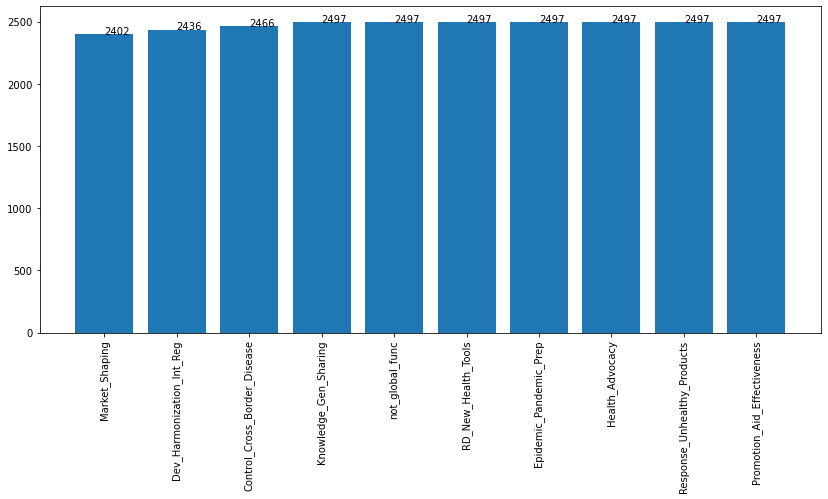

In [51]:
#plotting the distribution of categories. Creating column chart

#plotting the observation cat
plt.figure(figsize=(14,6))
plt.bar(df_aug_sorted["label_cat"], df_aug_sorted["cat_size_aug"])
plt.xticks(rotation=90)

for i, v in enumerate(df_aug_sorted["cat_size_aug"]):
    plt.text(i, v, str(v))

# we can see that we the augmented data has reduced the huge imbalance between different categories    

#### Feature Engineering

**We will first create features for train dataset and then we will create features for the test data

*** Feature creation for train data

In [52]:
#Feature creation

#Creating function for calculating the length and punctuation percentage feature in the description column of data
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text)-text.count(" ")), 3)*100

#creating feature of number of sentences in the text
def count_sent(text):
    return len(nltk.sent_tokenize(text))

In [53]:
#creating features for the train dataframe
train["body_len"]=train["description"].apply(lambda x: len(x)- x.count(" "))
train["body_sent"]=train["description"].apply(lambda x: count_sent(x))
train["punct%"]=train["description"].apply(lambda x: count_punct(x))

In [54]:
train.head()

,YEAR,Project.title,Purpose.Code,description,Value,label,body_len,body_sent,punct%
0,2017.0,Assessing Zika transmission dynamics and mitig...,12182.0,12182. Assessing Zika transmission dynamics an...,0.031470,Epidemic_Pandemic_Prep,1776,13,1.8
1,2017.0,HHS/CDC: RAPID RESPONSE TO EBOLA VIRAL DISEASE...,12250.0,12250. HHS/CDC: RAPID RESPONSE TO EBOLA VIRAL ...,0.643220,Epidemic_Pandemic_Prep,417,4,2.2
2,2015.0,Asian Vegetable Research & Development Center ...,13020.0,13020. Asian Vegetable Research & Development ...,0.515076,Response_Unhealthy_Products,276,4,5.1
3,2017.0,Enhanced Effective ICT,13040.0,13040. Enhanced Effective ICT. ENHANCED EFFECT...,0.000720,not_global_func,151,4,2.6
4,2017.0,"Avenir Health, Inc.",13030.0,"13030. Avenir Health, Inc.. AVENIR HEALTH, INC...",0.005065,Knowledge_Gen_Sharing,251,2,4.0


In [55]:
train.shape

(24783, 9)

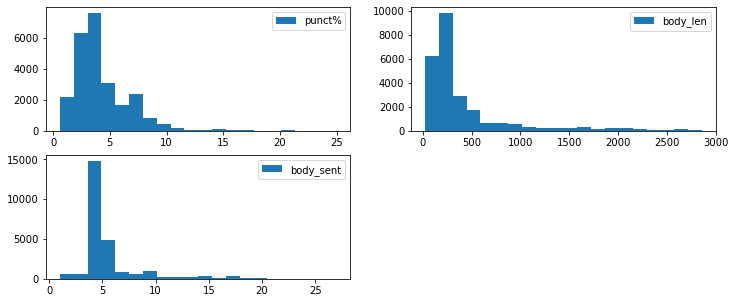

In [56]:
#lets evaluate the new features that we created and see if any of these need any transformation
plt.figure(figsize=(12,5))
plt.subplot(221)
plt.hist(train["punct%"], bins=20, label="punct%");
plt.legend();
plt.subplot(222)
plt.hist(train["body_len"], bins=20, label="body_len");
plt.legend();
plt.subplot(223)
plt.hist(train["body_sent"], bins=20, label="body_sent");
plt.legend();


It looks like `body_len`, and `body_sent` have a prominant right skew. `punt%` doesnt have a long skew but a transformation of all three variables might be helpful.

##### We will use the box-cox power transformation to transform "body_len", "punt%" "body_sent" feature vectors


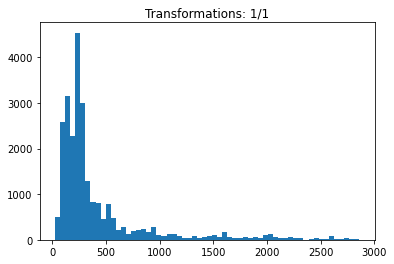

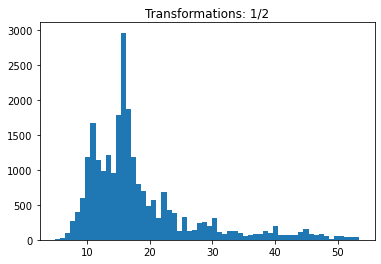

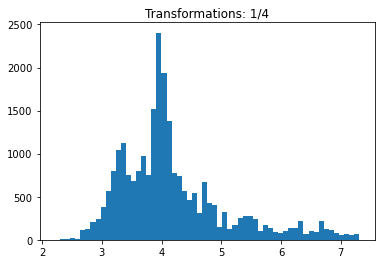

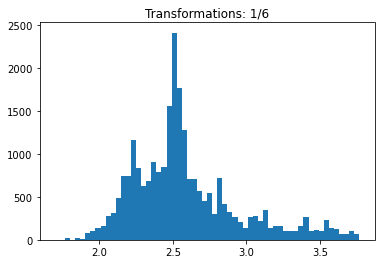

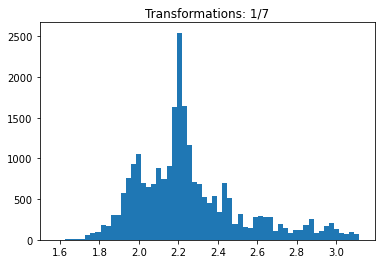

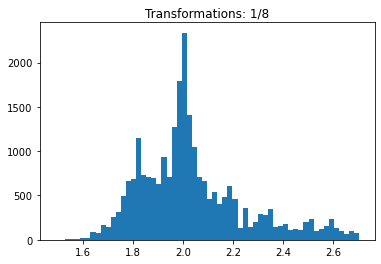

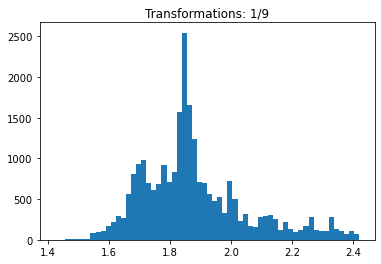

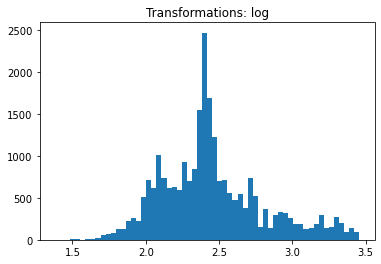

In [57]:
# checking different exponents on body len and printing the hist to see how the distribution changes

for i in [1,2,4,6,7, 8, 9]:
    plt.hist((train["body_len"])**(1/i), bins=60)
    plt.title("Transformations: 1/{}".format(str(i)))
    plt.show();
    
plt.hist(np.log10(train["body_len"]), bins=60)
plt.title("Transformations: log")
plt.show();

#after 6th power the histograms look very similar. However, the log transformation look better than than other powers

In [58]:
#applying logrithmic transformation on "body_len" column 
train["body_len"]=train["body_len"].apply(lambda x: np.log10(x))

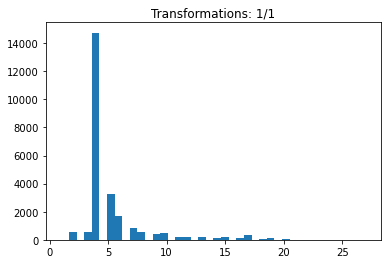

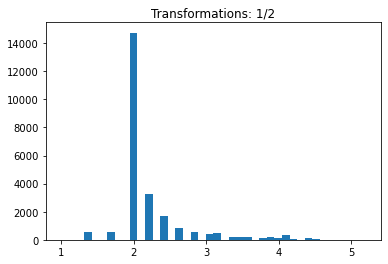

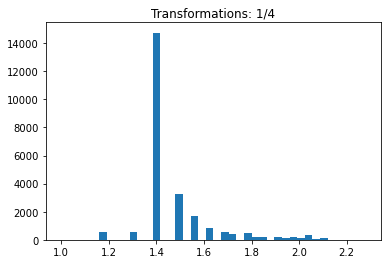

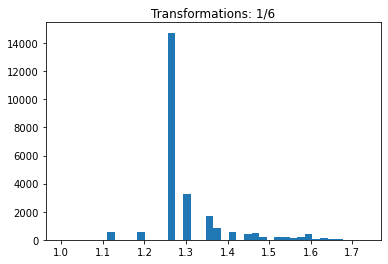

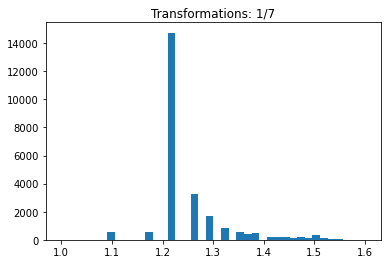

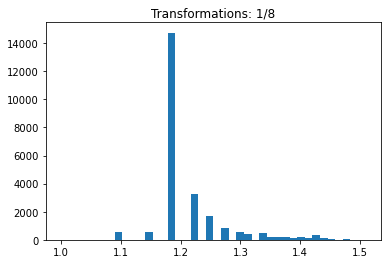

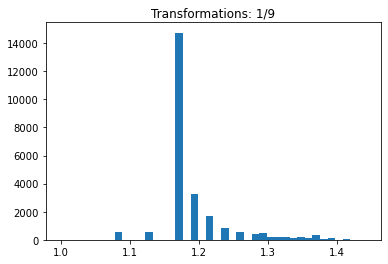

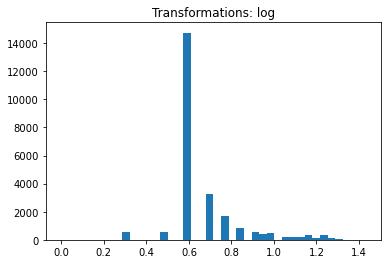

In [59]:
## checking different exponents on number of sentences and printing the hist to see how the distribution changes
for i in [1,2,4,6,7, 8, 9]:
    plt.hist((train["body_sent"])**(1/i), bins=40)
    plt.title("Transformations: 1/{}".format(str(i)))
    plt.show();
    
plt.hist(np.log10(train["body_sent"]), bins=40)
plt.title("Transformations: log")
plt.show();

# the log transformation look better than than other powers

In [60]:
#applying logrithmic transformation on "body_len" column
train["body_sent"]=train["body_sent"].apply(lambda x: np.log10(x))

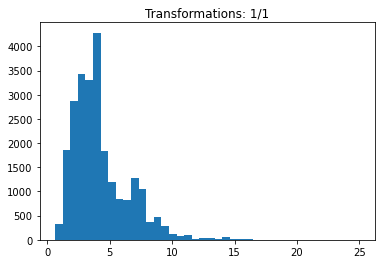

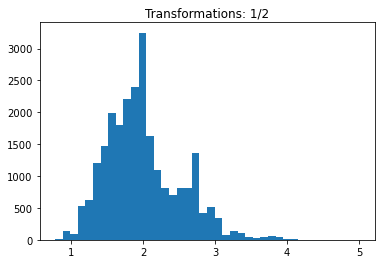

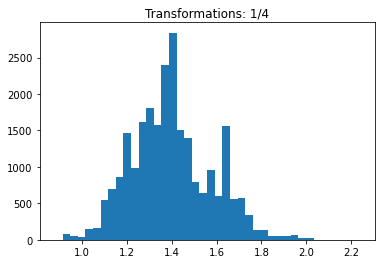

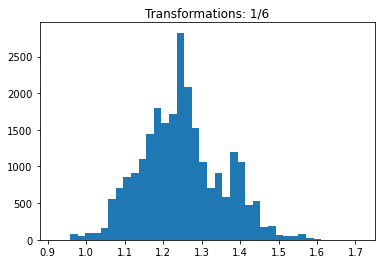

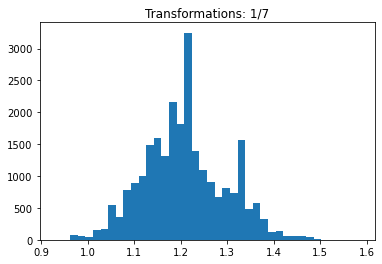

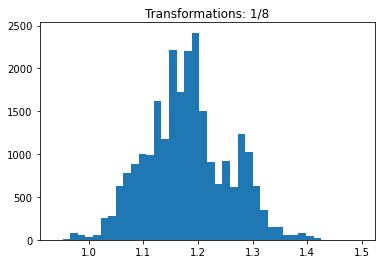

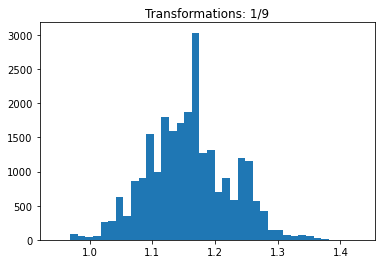

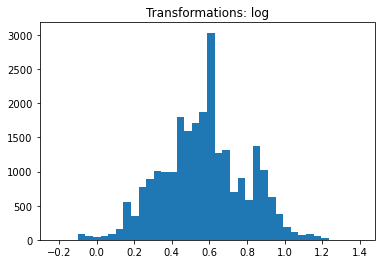

In [61]:
## checking different exponents on number of sentences and printing the hist to see how the distribution changes
for i in [1,2,4,6,7, 8, 9]:
    plt.hist((train["punct%"])**(1/i), bins=40)
    plt.title("Transformations: 1/{}".format(str(i)))
    plt.show();
    
plt.hist(np.log10(train["punct%"]), bins=40)
plt.title("Transformations: log")
plt.show();

#the 6th transformation look better than than other powers

In [62]:
train["punct%"]=train["punct%"].apply(lambda x: x**(1/6))

In [63]:
train.head()

,YEAR,Project.title,Purpose.Code,description,Value,label,body_len,body_sent,punct%
0,2017.0,Assessing Zika transmission dynamics and mitig...,12182.0,12182. Assessing Zika transmission dynamics an...,0.031470,Epidemic_Pandemic_Prep,3.249443,1.113943,1.102924
1,2017.0,HHS/CDC: RAPID RESPONSE TO EBOLA VIRAL DISEASE...,12250.0,12250. HHS/CDC: RAPID RESPONSE TO EBOLA VIRAL ...,0.643220,Epidemic_Pandemic_Prep,2.620136,0.602060,1.140435
2,2015.0,Asian Vegetable Research & Development Center ...,13020.0,13020. Asian Vegetable Research & Development ...,0.515076,Response_Unhealthy_Products,2.440909,0.602060,1.311983
3,2017.0,Enhanced Effective ICT,13040.0,13040. Enhanced Effective ICT. ENHANCED EFFECT...,0.000720,not_global_func,2.178977,0.602060,1.172633
4,2017.0,"Avenir Health, Inc.",13030.0,"13030. Avenir Health, Inc.. AVENIR HEALTH, INC...",0.005065,Knowledge_Gen_Sharing,2.399674,0.301030,1.259921


Now we will clean our data. This means we will do the following step:

    1. First we remove the punctuations.
    2. Then we will remove the stopwords like the, a, etc.
    3. Finally we will stem or lemmatize the work. We will explore both stemming and lemmatization.



In [64]:
#initializing stopwords, and stemmer
stopwords= nltk.corpus.stopwords.words("english")
ps= nltk.PorterStemmer()
wn=nltk.WordNetLemmatizer()

In [65]:
def clean_text(text):
    
    #removing punctuation
    text_nopunct="".join([char for char in text if char not in string.punctuation])
    
    #clean_punct=re.sub(r'\w*[0-9]\w*',"", text_nopunct)
    
    #spitting into token based on word end
    token=re.split("\W+",text_nopunct)
    
    #decided to use lemmetizer instead of stemmer as lemmetizer provids better results and also understands language semantics
    clean_lemma= [wn.lemmatize(word.upper()) for word in token if word not in stopwords] 
    
    #removing "NA" token
    remove_na= [word for word in clean_lemma if word !="NA"]
    
    #returning the cleaned text
    return remove_na

In [66]:
#cleaning the dataframe using clean_text()--we will not clean text here as our vectorizer will do this for us 
#using this function
#global_func["description"]=global_func["description"].apply(lambda x: clean_text(x))
#global_func["description"].head(10)

In [67]:
#shuffling the dataframe using sklearn function
train=shuffle(train)
train.head()

,YEAR,Project.title,Purpose.Code,description,Value,label,body_len,body_sent,punct%
15939,NaN,NaN,NaN,12220. New vaccine support (sagebrush state )....,NaN,Market_Shaping,2.120574,0.60206,1.376422
20991,NaN,NaN,NaN,"13030. Avenir Wellness, Inc. . AVENIR HEALTH, ...",NaN,Promotion_Aid_Effectiveness,2.408240,0.60206,1.254616
15182,NaN,NaN,NaN,12220. New vaccine support (NVS ). young VACCI...,NaN,Market_Shaping,1.949390,0.60206,1.442250
8198,2015.0,Vihara Innovation Network Private Limited,13020.0,13020. Vihara Innovation Network Private Limit...,0.137340,not_global_func,2.451786,0.60206,1.254616
5978,2013.0,GLOBAL HIV / AIDS PROGRAMMES - Gender Transfor...,13040.0,13040. GLOBAL HIV / AIDS PROGRAMMES - Gender T...,0.428005,not_global_func,2.826723,0.69897,1.207518


In [68]:
#resetting the index
train.reset_index(inplace=True, drop=True)

In [69]:
train.head()

,YEAR,Project.title,Purpose.Code,description,Value,label,body_len,body_sent,punct%
0,NaN,NaN,NaN,12220. New vaccine support (sagebrush state )....,NaN,Market_Shaping,2.120574,0.60206,1.376422
1,NaN,NaN,NaN,"13030. Avenir Wellness, Inc. . AVENIR HEALTH, ...",NaN,Promotion_Aid_Effectiveness,2.408240,0.60206,1.254616
2,NaN,NaN,NaN,12220. New vaccine support (NVS ). young VACCI...,NaN,Market_Shaping,1.949390,0.60206,1.442250
3,2015.0,Vihara Innovation Network Private Limited,13020.0,13020. Vihara Innovation Network Private Limit...,0.137340,not_global_func,2.451786,0.60206,1.254616
4,2013.0,GLOBAL HIV / AIDS PROGRAMMES - Gender Transfor...,13040.0,13040. GLOBAL HIV / AIDS PROGRAMMES - Gender T...,0.428005,not_global_func,2.826723,0.69897,1.207518


###### Feature creation for test data

In [70]:
#creating features for the train dataframe
test["body_len"]=test["description"].apply(lambda x: len(x)- x.count(" "))
test["body_sent"]=test["description"].apply(lambda x: count_sent(x))
test["punct%"]=test["description"].apply(lambda x: count_punct(x))

In [71]:
test

,YEAR,Project.title,Purpose.Code,description,Value,label,body_len,body_sent,punct%
0,2013,Projet de coopTration universitaire - Initiati...,12182,12182. Projet de coopTration universitaire - I...,0.073950,not_global_func,2804,23,2.4
1,2013,New vaccine support (NVS),12220,12220. New vaccine support (NVS). NEW VACCINE ...,0.096651,Market_Shaping,227,5,7.5
2,2015,EDCTP2: EUROPEAN AND DEVELOPING COUNTRIES CLIN...,12182,12182. EDCTP2: EUROPEAN AND DEVELOPING COUNTRI...,3.040122,RD_New_Health_Tools,463,6,3.9
3,2017,Scientific cooperation with other countries (n...,12182,12182. Scientific cooperation with other count...,0.038746,Knowledge_Gen_Sharing,419,6,3.3
4,2015,INT/Fund of the United Nations International D...,13010,13010. INT/Fund of the United Nations Internat...,0.914221,Response_Unhealthy_Products,645,9,1.9
...,...,...,...,...,...,...,...,...,...
2629,2017,AC_889_Mental health and substance abuse_12110,12110,12110. AC_889_Mental health and substance abus...,0.183818,Response_Unhealthy_Products,121,4,7.4
2630,2017,Global Health Innovative Technology Fund,13040,13040. Global Health Innovative Technology Fun...,0.750000,RD_New_Health_Tools,189,4,1.6
2631,2015,Implementation Science Research to Support Pro...,13040,13040. Implementation Science Research to Supp...,1.021588,Knowledge_Gen_Sharing,197,4,3.6
2632,2013,IR13-WB-RESEARCH FOR POLICY & ADVOCACY,12110,12110. IR13-WB-RESEARCH FOR POLICY & ADVOCACY....,0.000762,RD_New_Health_Tools,110,4,10.9


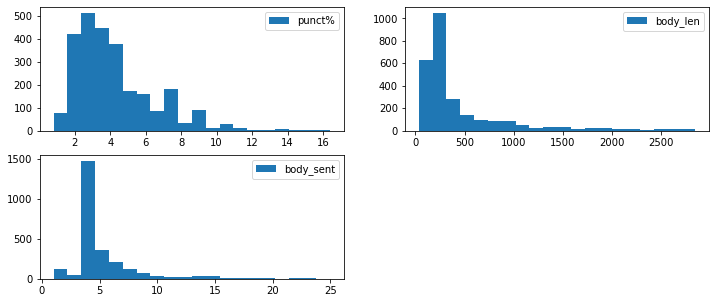

In [72]:
#lets evaluate the new features that we created and see if any of these need any transformation
plt.figure(figsize=(12,5))
plt.subplot(221)
plt.hist(test["punct%"], bins=20, label="punct%");
plt.legend();
plt.subplot(222)
plt.hist(test["body_len"], bins=20, label="body_len");
plt.legend();
plt.subplot(223)
plt.hist(test["body_sent"], bins=20, label="body_sent");
plt.legend();


**** We can see from the above charts that they have similar skew as the train data. So, we will use the same box-cox transformation with the same powers as used in the train data transformation

In [73]:
#applying logrithmic transformation on "body_len" column
test["body_len"]=test["body_len"].apply(lambda x: np.log10(x))

#applying logrithmic transformation on "body_len" column
test["body_sent"]=test["body_sent"].apply(lambda x: np.log10(x))

test["punct%"]=test["punct%"].apply(lambda x: x**(1/6))

test.head()

,YEAR,Project.title,Purpose.Code,description,Value,label,body_len,body_sent,punct%
0,2013,Projet de coopTration universitaire - Initiati...,12182,12182. Projet de coopTration universitaire - I...,0.073950,not_global_func,3.447778,1.361728,1.157094
1,2013,New vaccine support (NVS),12220,12220. New vaccine support (NVS). NEW VACCINE ...,0.096651,Market_Shaping,2.356026,0.698970,1.399083
2,2015,EDCTP2: EUROPEAN AND DEVELOPING COUNTRIES CLIN...,12182,12182. EDCTP2: EUROPEAN AND DEVELOPING COUNTRI...,3.040122,RD_New_Health_Tools,2.665581,0.778151,1.254616
3,2017,Scientific cooperation with other countries (n...,12182,12182. Scientific cooperation with other count...,0.038746,Knowledge_Gen_Sharing,2.622214,0.778151,1.220166
4,2015,INT/Fund of the United Nations International D...,13010,13010. INT/Fund of the United Nations Internat...,0.914221,Response_Unhealthy_Products,2.809560,0.954243,1.112907


#### Vectorizing Raw Data

In [74]:
##Here we use two types of vectorizers--TF-IDF  
##We can use either to check which gives better results with the algorithms

#TF-IDF--Vectorizing for train data
tfidf_vect= TfidfVectorizer(analyzer=clean_text)
x_tfidf= tfidf_vect.fit_transform(train["description"])
print(x_tfidf.shape)
print(tfidf_vect.get_feature_names())


(24783, 22257)
['', '0', '000', '001', '001ELIMINATION', '002', '003', '005', '007', '01', '01008', '01102012', '012', '015', '015162', '016', '019', '019651', '02', '02002', '02003', '02004', '02007', '02008', '0217', '025', '029', '03', '04', '05', '059', '06', '075', '08', '08SER013112', '09', '0B', '1', '10', '100', '1000', '100000', '1000000', '10000000', '1001', '100160', '1009', '100ODA', '101', '1014', '10141', '1015', '1018', '101812', '101818', '1019', '102', '1020', '1020FOLD', '1024', '102692', '103234', '103457', '103760', '104', '104051', '105', '105053', '105819', '106439', '106641', '107', '1075000', '10CO1064ACHPARAGUAY', '10VALENT', '11', '110', '1100717', '1101174', '1101576JFR', '1106', '111', '1110', '1111', '1113', '1114', '112', '113', '114', '115', '1152082', '116', '116E', '117', '118', '119', '11TH', '12', '120', '1200', '12000', '1200MG', '121', '12110', '12181', '12182', '12191', '12200', '12220', '12230', '12240', '12240CLEOPROTEIN', '12250', '12250ECTED', 

In [75]:
#the x_tfidf is sparse matrix. Lets look at it in data frame form
x_tfidf_df= pd.DataFrame(x_tfidf.toarray())

x_tfidf_df


,0,1,2,3,4,5,6,7,8,9,...,22247,22248,22249,22250,22251,22252,22253,22254,22255,22256
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
# lets change the name of coulmns from number to actual words which these coulmns represent
x_tfidf_df.columns= tfidf_vect.get_feature_names()

x_tfidf_df

,,0,000,001,001ELIMINATION,002,003,005,007,01,...,ZOONOSESCONTROLRESULT,ZOONOSESWITHIN,ZOONOSIS,ZOONOTIC,ZPCT,ZTRTKORT,ZU,ZUR,ZVITAMBO,ZZHEAGENHEALTH
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
#concatenating all  the features

x_tfidf_feat = pd.concat([train["body_len"],train["body_sent"], train["punct%"], pd.DataFrame(x_tfidf.toarray())], axis=1)
x_tfidf_feat.head()

,body_len,body_sent,punct%,0,1,2,3,4,5,6,...,22247,22248,22249,22250,22251,22252,22253,22254,22255,22256
0,2.120574,0.60206,1.376422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.408240,0.60206,1.254616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.949390,0.60206,1.442250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.451786,0.60206,1.254616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.826723,0.69897,1.207518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
#Countvectorizer--Vectorizing for train data
#count_vect=CountVectorizer(analyzer=clean_text)
#x_count=count_vect.fit_transform(train["description"])
#x_count_feat=pd.concat([train["body_len"], train["punct%"], pd.DataFrame(x_count.toarray())], axis=1)
#x_count_feat.head()

In [79]:
#vectorizing test data

##Here we use two types of vectorizers--TF-IDF and Countvectorizer. 
##We can use either to check which gives better results with the algorithms

#TF-IDF--Vectorizing for test data
x_tfidf_test= tfidf_vect.transform(test["description"])
print(x_tfidf_test.shape)


(2634, 22257)


In [80]:
#the x_tfidf is sparse matrix. Lets look at it in data frame form
x_tfidf_test_df= pd.DataFrame(x_tfidf_test.toarray())

x_tfidf_test_df


,0,1,2,3,4,5,6,7,8,9,...,22247,22248,22249,22250,22251,22252,22253,22254,22255,22256
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
# lets change the name of coulmns from number to actual words which these coulmns represent
x_tfidf_test_df.columns= tfidf_vect.get_feature_names()

x_tfidf_test_df

,,0,000,001,001ELIMINATION,002,003,005,007,01,...,ZOONOSESCONTROLRESULT,ZOONOSESWITHIN,ZOONOSIS,ZOONOTIC,ZPCT,ZTRTKORT,ZU,ZUR,ZVITAMBO,ZZHEAGENHEALTH
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
#concatenating all  the features

x_tfidf_test_feat = pd.concat([test["body_len"],test["body_sent"], test["punct%"], pd.DataFrame(x_tfidf_test.toarray())], axis=1)
x_tfidf_test_feat.head()

,body_len,body_sent,punct%,0,1,2,3,4,5,6,...,22247,22248,22249,22250,22251,22252,22253,22254,22255,22256
0,3.447778,1.361728,1.157094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.356026,0.698970,1.399083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.665581,0.778151,1.254616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.622214,0.778151,1.220166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.809560,0.954243,1.112907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


***Exploring RandomForestClassifier***

##### Applying tf-idf

##### Cross-Validation for Hyperparameter tuning--Random forest

In [776]:
rf_0 = RandomForestClassifier(random_state = 8)

print('Parameters currently in use:\n')
pprint(rf_0.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 8,
 'verbose': 0,
 'warm_start': False}


We'll tune the following ones:

* n_estimators = number of trees in the forest.
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)

#####  Grid Search Cross Validation (GRIDSEARCHCV)

In [ ]:

# Create the parameter grid based on the results of random search 

# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 800, num = 4)]

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 3)]
max_depth.append(None)

param_grid = {
    #'bootstrap': bootstrap,
    'max_depth': max_depth,
    #'max_features': max_features,
    #'min_samples_leaf': min_samples_leaf,
    #'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(x_tfidf_feat, train["label"])

Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [ ]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

In [765]:
#Exploring RandomForestClassifier using tfidf
rf = RandomForestClassifier (n_estimators=500, max_depth=None, n_jobs = -1)
# generate your cross-validation prediction with 5 fold Stratified sampling
y_pred=cross_val_predict(rf, x_tfidf_feat, train["label"], cv=5, n_jobs=-1)
print(classification_report(train["label"], y_pred))

MemoryError: Unable to allocate 1.44 GiB for an array with shape (17679, 21914) and data type float32

In [445]:
#creating confusion matrix
confusion_matrix(list(train["label"]), list(y_pred))

array([[1547,    0,   17,   18,    4,    3,    0,    0,    1,    1,    8],
       [   0, 1656,    0,    2,    0,    0,    0,    0,    0,    0,    1],
       [   2,    0, 1481,    0,    2,    1,    0,    5,    7,    0,    6],
       [   7,    3,    1, 1366,    9,    0,    0,    0,    6,    2,   12],
       [  12,    3,    8,    6, 1248,    5,    4,   13,  199,    5,  166],
       [   0,    0,    0,    0,    0, 1667,    0,    0,    0,    0,    2],
       [   0,    0,    0,    0,    0,    0, 1669,    0,    0,    0,    0],
       [   0,    0,    2,    4,    6,    0,    0, 1657,    0,    0,    0],
       [  18,    0,    7,    3,   76,    2,    0,    8, 1527,    0,   28],
       [   0,    0,    0,    0,    3,    0,    0,    0,    0, 1653,    0],
       [  25,    2,   46,   16,  120,    5,    3,    0,  100,    9, 1343]],
      dtype=int64)

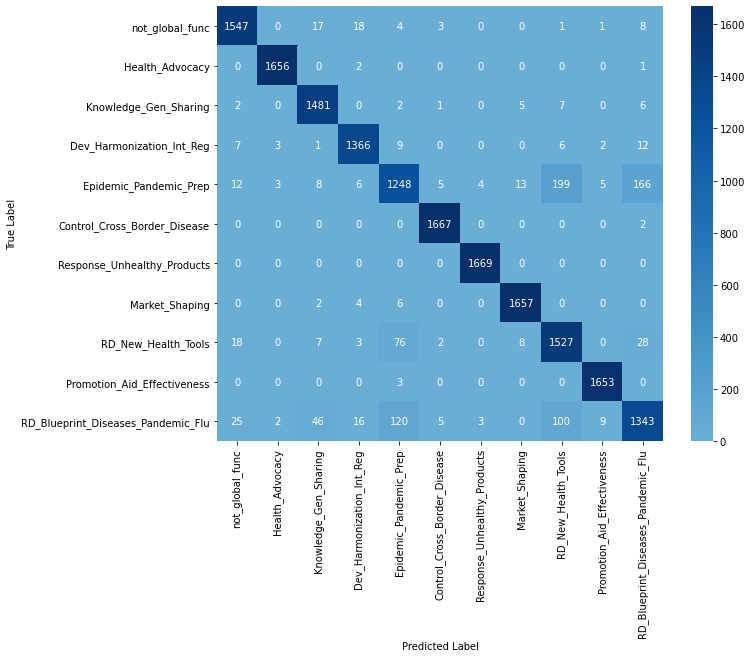

In [447]:
#heatmap of confusion matrix 
conf_mat_rf=confusion_matrix(list(train["label"]),list(y_pred))
conf_mat_df_rf= pd.DataFrame(conf_mat_rf,
                     index = ['not_global_func',
 'Health_Advocacy',
 'Knowledge_Gen_Sharing',
 'Dev_Harmonization_Int_Reg',
 'Epidemic_Pandemic_Prep',
 'Control_Cross_Border_Disease',
 'Response_Unhealthy_Products',
 'Market_Shaping',
 'RD_New_Health_Tools',
 'Promotion_Aid_Effectiveness',
 'RD_Blueprint_Diseases_Pandemic_Flu'], 
                             
                     columns = ['not_global_func',
 'Health_Advocacy',
 'Knowledge_Gen_Sharing',
 'Dev_Harmonization_Int_Reg',
 'Epidemic_Pandemic_Prep',
 'Control_Cross_Border_Disease',
 'Response_Unhealthy_Products',
 'Market_Shaping',
 'RD_New_Health_Tools',
 'Promotion_Aid_Effectiveness',
 'RD_Blueprint_Diseases_Pandemic_Flu'])

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_df_rf, annot=True, cmap="Blues",  fmt='g')          
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

##### Applying the classifier on Holdout Test set (Train and Test set separately)

##### Random Forest classifier

In [83]:
#instantiating the model and fitting it on the train set
rf=RandomForestClassifier(n_estimators=150, max_depth=None, class_weight="balanced")

#fitting the model on training data
rf_model=rf.fit(x_tfidf_feat, train["label"])


In [84]:
#most important list of features that random forest uses for learning
sorted(zip(rf_model.feature_importances_, x_tfidf_feat.columns), reverse=True)[0:10]

#our created features are in top 10 importance

[(0.01406884828187627, 'body_len'),
 (0.013596000852279418, 'punct%'),
 (0.0117001025789697, 103),
 (0.011242446348542729, 21382),
 (0.010128326727385078, 14074),
 (0.009306932480380812, 1973),
 (0.009296777085480119, 112),
 (0.008799989592929507, 108),
 (0.008501522586901431, 19695),
 (0.007856264630539404, 17468)]

In [85]:
#predicting the categories using the trained model on test set 
y_pred_rf=rf_model.predict(x_tfidf_test_feat)

#printing classification results
print(classification_report(test["label"], y_pred_rf)) 

                              precision    recall  f1-score   support

Control_Cross_Border_Disease       0.95      0.95      0.95       310
   Dev_Harmonization_Int_Reg       0.83      0.81      0.82        53
      Epidemic_Pandemic_Prep       0.92      0.85      0.88       328
             Health_Advocacy       0.92      0.91      0.91       203
       Knowledge_Gen_Sharing       0.76      0.76      0.76       585
              Market_Shaping       0.98      0.95      0.96       224
 Promotion_Aid_Effectiveness       0.77      0.35      0.48        57
         RD_New_Health_Tools       0.67      0.80      0.73       330
 Response_Unhealthy_Products       0.85      0.77      0.81        60
             not_global_func       0.79      0.80      0.80       484

                    accuracy                           0.83      2634
                   macro avg       0.84      0.80      0.81      2634
                weighted avg       0.83      0.83      0.83      2634



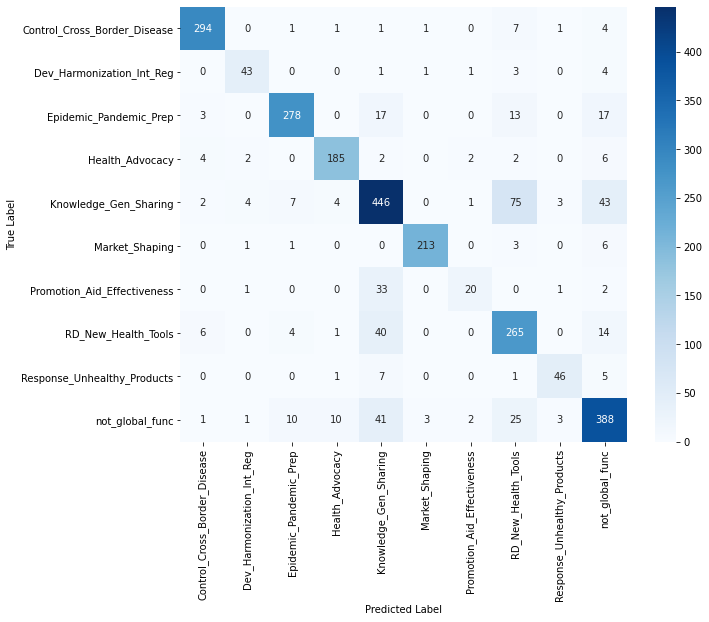

In [86]:
#heatmap of confusion matrix 
conf_mat_rf=confusion_matrix(list(test["label"]),list(y_pred_rf))
conf_mat_df_rf= pd.DataFrame(conf_mat_rf,
                     index = np.unique(test["label"]), 
                     columns = np.unique(y_pred_rf))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_df_rf, annot=True, cmap="Blues",  fmt='g')          
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

###### saving the RF model on disk

In [152]:
filename = 'finalized_model_rf.sav'
pickle.dump(rf_model, open(filename, 'wb'))

##### Checking how well finance prediction match:calculating the finance based on the predicted categories from RF model

In [153]:
test_fin_calc=pd.concat([test, pd.DataFrame(y_pred_rf)], axis=1)

test_fin_calc=test_fin_calc.rename(columns={0:"class_pred"})

test_fin_calc.head()

,YEAR,Project.title,Purpose.Code,description,Value,label,body_len,body_sent,punct%,class_pred
0,2013,Projet de coopTration universitaire - Initiati...,12182,12182. Projet de coopTration universitaire - I...,0.073950,not_global_func,3.447778,1.361728,1.157094,not_global_func
1,2013,New vaccine support (NVS),12220,12220. New vaccine support (NVS). NEW VACCINE ...,0.096651,Market_Shaping,2.356026,0.698970,1.399083,Market_Shaping
2,2015,EDCTP2: EUROPEAN AND DEVELOPING COUNTRIES CLIN...,12182,12182. EDCTP2: EUROPEAN AND DEVELOPING COUNTRI...,3.040122,RD_New_Health_Tools,2.665581,0.778151,1.254616,RD_New_Health_Tools
3,2017,Scientific cooperation with other countries (n...,12182,12182. Scientific cooperation with other count...,0.038746,Knowledge_Gen_Sharing,2.622214,0.778151,1.220166,Knowledge_Gen_Sharing
4,2015,INT/Fund of the United Nations International D...,13010,13010. INT/Fund of the United Nations Internat...,0.914221,Response_Unhealthy_Products,2.809560,0.954243,1.112907,Health_Advocacy


In [154]:
#Counting the number of projects in actual label categories
print("not_global_func:", len(test_fin_calc[test_fin_calc["label"]=="not_global_func"]))
print("Control_Cross_Border_Disease:", len(test_fin_calc[test_fin_calc["label"]=="Control_Cross_Border_Disease"]))
print("Health_Advocacy:", len(test_fin_calc[test_fin_calc["label"]=="Health_Advocacy"]))
print("Knowledge_Gen_Sharing:", len(test_fin_calc[test_fin_calc["label"]=="Knowledge_Gen_Sharing"]))
print("Dev_Harmonization_Int_Reg:", len(test_fin_calc[test_fin_calc["label"]=="Dev_Harmonization_Int_Reg"]))
print("Epidemic_Pandemic_Prep:", len(test_fin_calc[test_fin_calc["label"]=="Epidemic_Pandemic_Prep"]))
print("Response_Unhealthy_Products:", len(test_fin_calc[test_fin_calc["label"]=="Response_Unhealthy_Products"]))
print("Market_Shaping:", len(test_fin_calc[test_fin_calc["label"]=="Market_Shaping"]))
print("RD_New_Health_Tools:", len(test_fin_calc[test_fin_calc["label"]=="RD_New_Health_Tools"]))
print("Promotion_Aid_Effectiveness:", len(test_fin_calc[test_fin_calc["label"]=="Promotion_Aid_Effectiveness"]))

not_global_func: 484
Control_Cross_Border_Disease: 310
Health_Advocacy: 203
Knowledge_Gen_Sharing: 585
Dev_Harmonization_Int_Reg: 53
Epidemic_Pandemic_Prep: 328
Response_Unhealthy_Products: 60
Market_Shaping: 224
RD_New_Health_Tools: 330
Promotion_Aid_Effectiveness: 57


In [155]:
#Counting the number of projects in predicted categories
print("not_global_func:", len(test_fin_calc[test_fin_calc["class_pred"]=="not_global_func"]))
print("Control_Cross_Border_Disease:", len(test_fin_calc[test_fin_calc["class_pred"]=="Control_Cross_Border_Disease"]))
print("Health_Advocacy:", len(test_fin_calc[test_fin_calc["class_pred"]=="Health_Advocacy"]))
print("Knowledge_Gen_Sharing:", len(test_fin_calc[test_fin_calc["class_pred"]=="Knowledge_Gen_Sharing"]))
print("Dev_Harmonization_Int_Reg:", len(test_fin_calc[test_fin_calc["class_pred"]=="Dev_Harmonization_Int_Reg"]))
print("Epidemic_Pandemic_Prep:", len(test_fin_calc[test_fin_calc["class_pred"]=="Epidemic_Pandemic_Prep"]))
print("Response_Unhealthy_Products:", len(test_fin_calc[test_fin_calc["class_pred"]=="Response_Unhealthy_Products"]))
print("Market_Shaping:", len(test_fin_calc[test_fin_calc["class_pred"]=="Market_Shaping"]))
print("RD_New_Health_Tools:", len(test_fin_calc[test_fin_calc["class_pred"]=="RD_New_Health_Tools"]))
print("Promotion_Aid_Effectiveness:", len(test_fin_calc[test_fin_calc["class_pred"]=="Promotion_Aid_Effectiveness"]))

not_global_func: 489
Control_Cross_Border_Disease: 310
Health_Advocacy: 202
Knowledge_Gen_Sharing: 588
Dev_Harmonization_Int_Reg: 52
Epidemic_Pandemic_Prep: 301
Response_Unhealthy_Products: 54
Market_Shaping: 218
RD_New_Health_Tools: 394
Promotion_Aid_Effectiveness: 26


In [156]:
#gpg amount based on the predicted categories
dah_gpg=test_fin_calc.groupby(["class_pred"]).agg({"Value":np.sum})

dah_gpg=dah_gpg.sort_values("Value").reset_index()

dah_gpg=dah_gpg.round(2)
dah_gpg

,class_pred,Value
0,Dev_Harmonization_Int_Reg,19.17
1,Response_Unhealthy_Products,21.81
2,Promotion_Aid_Effectiveness,35.69
3,Knowledge_Gen_Sharing,220.50
4,Health_Advocacy,239.70
5,Epidemic_Pandemic_Prep,271.72
6,RD_New_Health_Tools,316.07
7,Control_Cross_Border_Disease,485.64
8,Market_Shaping,628.95
9,not_global_func,911.98


In [157]:
#gpg finance based on predicted categories in the test dataset
dah_gpg[dah_gpg["class_pred"]!="not_global_func"].sum()

class_pred    Dev_Harmonization_Int_RegResponse_Unhealthy_Pr...
Value                                                   2239.25
dtype: object

In [158]:
#gpg finance based on human classification in the test dataset

dah_gpg_human=test_fin_calc.groupby(["label"]).agg({"Value":np.sum})

dah_gpg_human=dah_gpg_human.sort_values("Value").reset_index()

dah_gpg_human=dah_gpg_human.round(2)
dah_gpg_human

,label,Value
0,Response_Unhealthy_Products,18.40
1,Dev_Harmonization_Int_Reg,22.02
2,Promotion_Aid_Effectiveness,32.14
3,Knowledge_Gen_Sharing,222.27
4,Health_Advocacy,242.07
5,Epidemic_Pandemic_Prep,276.48
6,RD_New_Health_Tools,293.64
7,Control_Cross_Border_Disease,527.31
8,Market_Shaping,611.52
9,not_global_func,905.36


In [159]:
#gpg finance based on human classified categories in the test dataset
dah_gpg_human[dah_gpg_human["label"]!="not_global_func"].sum()

label    Response_Unhealthy_ProductsDev_Harmonization_I...
Value                                              2245.85
dtype: object

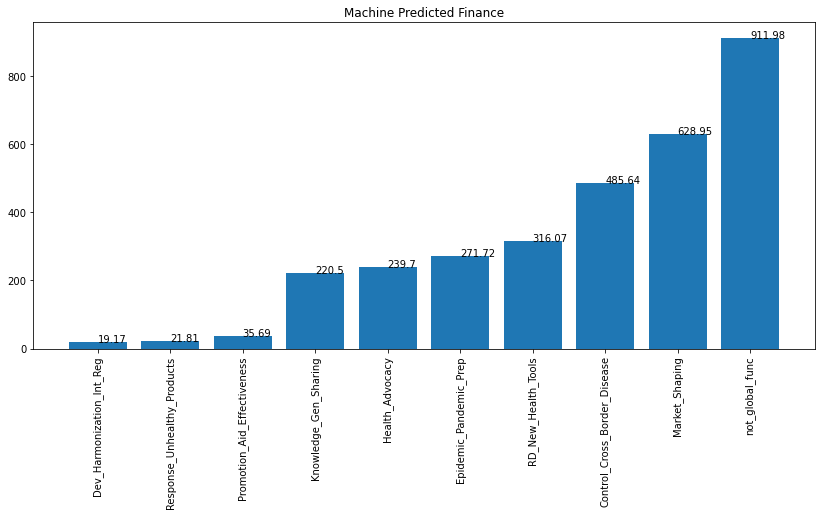

In [160]:
#plotting the distribution of categories. Creating column chart

#plotting the observation cat
plt.figure(figsize=(14,6))
plt.bar(dah_gpg["class_pred"], dah_gpg["Value"])
plt.xticks(rotation=90)
plt.title("Machine Predicted Finance")

for i, v in enumerate(dah_gpg["Value"]):
    plt.text(i, v, str(v))


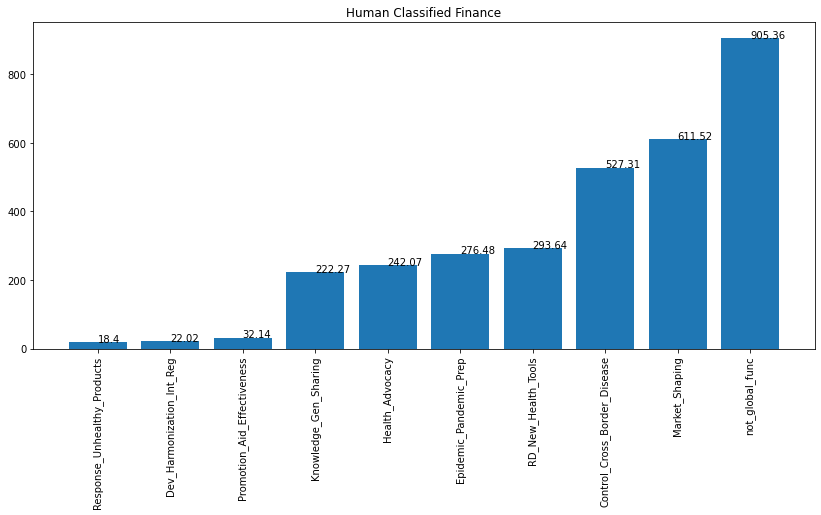

In [161]:
#actual values in different categories

dah_gpg_act=test_fin_calc.groupby(["label"]).agg({"Value":np.sum})

dah_gpg_act=dah_gpg_act.sort_values("Value").reset_index()

dah_gpg_act=dah_gpg_act.round(2)

#plotting the distribution of categories. Creating column chart

#plotting the observation cat
plt.figure(figsize=(14,6))
plt.bar(dah_gpg_act["label"], dah_gpg_act["Value"])
plt.xticks(rotation=90)
plt.title("Human Classified Finance")

for i, v in enumerate(dah_gpg_act["Value"]):
    plt.text(i, v, str(v))

##### XgBOOST

In [114]:
# xgb = XGBClassifier( n_estimators=150, learning_rate=0.3, 
#                           max_depth=None)

xgb = XGBClassifier(n_estimators=150)


#fitting the model on training data
xgb_model=xgb.fit(x_tfidf_feat, train["label"])

C:\Users\sd282\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:22:30] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [115]:
#predicting the categories using the trained model on test set 
y_pred_xgb=xgb_model.predict(x_tfidf_test_feat)

In [116]:
#printing classification results
print(classification_report(test["label"], y_pred_xgb)) 

                              precision    recall  f1-score   support

Control_Cross_Border_Disease       0.94      0.95      0.94       310
   Dev_Harmonization_Int_Reg       0.86      0.83      0.85        53
      Epidemic_Pandemic_Prep       0.92      0.87      0.89       328
             Health_Advocacy       0.89      0.91      0.90       203
       Knowledge_Gen_Sharing       0.75      0.82      0.78       585
              Market_Shaping       0.97      0.96      0.97       224
 Promotion_Aid_Effectiveness       0.77      0.35      0.48        57
         RD_New_Health_Tools       0.73      0.75      0.74       330
 Response_Unhealthy_Products       0.88      0.85      0.86        60
             not_global_func       0.81      0.79      0.80       484

                    accuracy                           0.84      2634
                   macro avg       0.85      0.81      0.82      2634
                weighted avg       0.84      0.84      0.83      2634



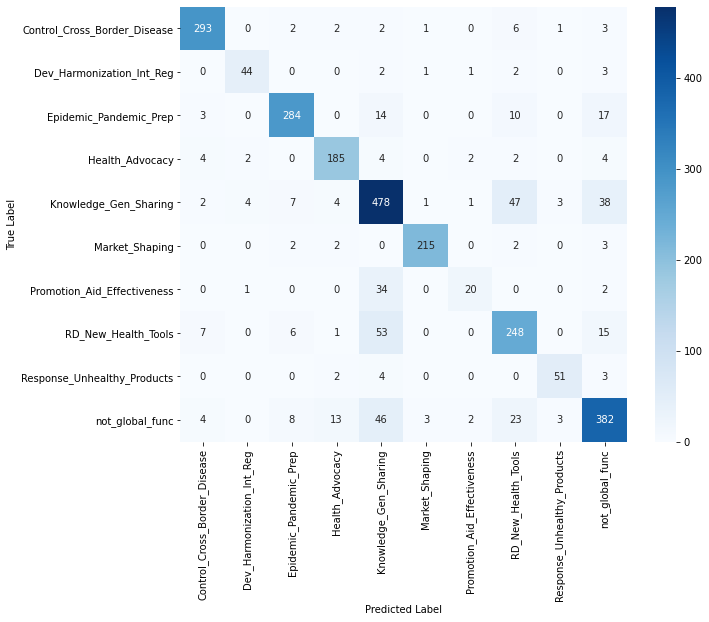

In [117]:
#heatmap of confusion matrix 
conf_mat_rf=confusion_matrix(list(test["label"]),list(y_pred_xgb))
conf_mat_df_rf= pd.DataFrame(conf_mat_rf,
                     index = np.unique(test["label"]), 
                     columns = np.unique(y_pred_xgb))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_df_rf, annot=True, cmap="Blues",  fmt='g')          
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

###### saving the xgboost model on disk

In [118]:
filename = 'finalized_model_xgboost.sav'
pickle.dump(xgb_model, open(filename, 'wb'))

##### Checking how well finance prediction match:calculating the finance based on the predicted categories from XGBoost model

In [119]:
test_fin_calc_xg=pd.concat([test, pd.DataFrame(y_pred_xgb)], axis=1)

test_fin_calc_xg=test_fin_calc_xg.rename(columns={0:"class_pred"})

test_fin_calc_xg.head()

,YEAR,Project.title,Purpose.Code,description,Value,label,body_len,body_sent,punct%,class_pred
0,2013,Projet de coopTration universitaire - Initiati...,12182,12182. Projet de coopTration universitaire - I...,0.073950,not_global_func,3.447778,1.361728,1.157094,not_global_func
1,2013,New vaccine support (NVS),12220,12220. New vaccine support (NVS). NEW VACCINE ...,0.096651,Market_Shaping,2.356026,0.698970,1.399083,Market_Shaping
2,2015,EDCTP2: EUROPEAN AND DEVELOPING COUNTRIES CLIN...,12182,12182. EDCTP2: EUROPEAN AND DEVELOPING COUNTRI...,3.040122,RD_New_Health_Tools,2.665581,0.778151,1.254616,RD_New_Health_Tools
3,2017,Scientific cooperation with other countries (n...,12182,12182. Scientific cooperation with other count...,0.038746,Knowledge_Gen_Sharing,2.622214,0.778151,1.220166,Knowledge_Gen_Sharing
4,2015,INT/Fund of the United Nations International D...,13010,13010. INT/Fund of the United Nations Internat...,0.914221,Response_Unhealthy_Products,2.809560,0.954243,1.112907,Health_Advocacy


In [120]:
#Counting the number of projects in actual label categories
print("not_global_func:", len(test_fin_calc_xg[test_fin_calc_xg["label"]=="not_global_func"]))
print("Control_Cross_Border_Disease:", len(test_fin_calc_xg[test_fin_calc_xg["label"]=="Control_Cross_Border_Disease"]))
print("Health_Advocacy:", len(test_fin_calc_xg[test_fin_calc_xg["label"]=="Health_Advocacy"]))
print("Knowledge_Gen_Sharing:", len(test_fin_calc_xg[test_fin_calc_xg["label"]=="Knowledge_Gen_Sharing"]))
print("Dev_Harmonization_Int_Reg:", len(test_fin_calc_xg[test_fin_calc_xg["label"]=="Dev_Harmonization_Int_Reg"]))
print("Epidemic_Pandemic_Prep:", len(test_fin_calc_xg[test_fin_calc_xg["label"]=="Epidemic_Pandemic_Prep"]))
print("Response_Unhealthy_Products:", len(test_fin_calc_xg[test_fin_calc_xg["label"]=="Response_Unhealthy_Products"]))
print("Market_Shaping:", len(test_fin_calc_xg[test_fin_calc_xg["label"]=="Market_Shaping"]))
print("RD_New_Health_Tools:", len(test_fin_calc_xg[test_fin_calc_xg["label"]=="RD_New_Health_Tools"]))
print("Promotion_Aid_Effectiveness:", len(test_fin_calc_xg[test_fin_calc_xg["label"]=="Promotion_Aid_Effectiveness"]))

not_global_func: 484
Control_Cross_Border_Disease: 310
Health_Advocacy: 203
Knowledge_Gen_Sharing: 585
Dev_Harmonization_Int_Reg: 53
Epidemic_Pandemic_Prep: 328
Response_Unhealthy_Products: 60
Market_Shaping: 224
RD_New_Health_Tools: 330
Promotion_Aid_Effectiveness: 57


In [121]:
#Counting the number of projects in projected label categories
print("not_global_func:", len(test_fin_calc_xg[test_fin_calc_xg["class_pred"]=="not_global_func"]))
print("Control_Cross_Border_Disease:", len(test_fin_calc_xg[test_fin_calc_xg["class_pred"]=="Control_Cross_Border_Disease"]))
print("Health_Advocacy:", len(test_fin_calc_xg[test_fin_calc_xg["class_pred"]=="Health_Advocacy"]))
print("Knowledge_Gen_Sharing:", len(test_fin_calc_xg[test_fin_calc_xg["class_pred"]=="Knowledge_Gen_Sharing"]))
print("Dev_Harmonization_Int_Reg:", len(test_fin_calc_xg[test_fin_calc_xg["class_pred"]=="Dev_Harmonization_Int_Reg"]))
print("Epidemic_Pandemic_Prep:", len(test_fin_calc_xg[test_fin_calc_xg["class_pred"]=="Epidemic_Pandemic_Prep"]))
print("Response_Unhealthy_Products:", len(test_fin_calc_xg[test_fin_calc_xg["class_pred"]=="Response_Unhealthy_Products"]))
print("Market_Shaping:", len(test_fin_calc_xg[test_fin_calc_xg["class_pred"]=="Market_Shaping"]))
print("RD_New_Health_Tools:", len(test_fin_calc_xg[test_fin_calc_xg["class_pred"]=="RD_New_Health_Tools"]))
print("Promotion_Aid_Effectiveness:", len(test_fin_calc_xg[test_fin_calc_xg["class_pred"]=="Promotion_Aid_Effectiveness"]))

not_global_func: 470
Control_Cross_Border_Disease: 313
Health_Advocacy: 209
Knowledge_Gen_Sharing: 637
Dev_Harmonization_Int_Reg: 51
Epidemic_Pandemic_Prep: 309
Response_Unhealthy_Products: 58
Market_Shaping: 221
RD_New_Health_Tools: 340
Promotion_Aid_Effectiveness: 26


In [122]:
#CGH amount based on the predicted categories
dah_gpg_xg=test_fin_calc_xg.groupby(["class_pred"]).agg({"Value":np.sum})

dah_gpg_xg=dah_gpg_xg.sort_values("Value").reset_index()

dah_gpg_xg=dah_gpg_xg.round(2)
dah_gpg_xg

,class_pred,Value
0,Dev_Harmonization_Int_Reg,17.87
1,Response_Unhealthy_Products,22.40
2,Promotion_Aid_Effectiveness,35.69
3,Knowledge_Gen_Sharing,238.67
4,Health_Advocacy,261.35
5,Epidemic_Pandemic_Prep,275.92
6,RD_New_Health_Tools,281.73
7,Control_Cross_Border_Disease,493.53
8,Market_Shaping,637.52
9,not_global_func,886.56


In [123]:
#CGH finance based on predicted categories in the test dataset
dah_gpg_xg[dah_gpg_xg["class_pred"]!="not_global_func"].sum()

class_pred    Dev_Harmonization_Int_RegResponse_Unhealthy_Pr...
Value                                                   2264.68
dtype: object

In [124]:
#CGH finance based on human classification in the test dataset

dah_gpg_human_xg=test_fin_calc_xg.groupby(["label"]).agg({"Value":np.sum})

dah_gpg_human_xg=dah_gpg_human_xg.sort_values("Value").reset_index()

dah_gpg_human_xg=dah_gpg_human_xg.round(2)
dah_gpg_human_xg

,label,Value
0,Response_Unhealthy_Products,18.40
1,Dev_Harmonization_Int_Reg,22.02
2,Promotion_Aid_Effectiveness,32.14
3,Knowledge_Gen_Sharing,222.27
4,Health_Advocacy,242.07
5,Epidemic_Pandemic_Prep,276.48
6,RD_New_Health_Tools,293.64
7,Control_Cross_Border_Disease,527.31
8,Market_Shaping,611.52
9,not_global_func,905.36


In [125]:
#CGH finance based on human classified categories in the test dataset
dah_gpg_human_xg[dah_gpg_human_xg["label"]!="not_global_func"].sum()

label    Response_Unhealthy_ProductsDev_Harmonization_I...
Value                                              2245.85
dtype: object

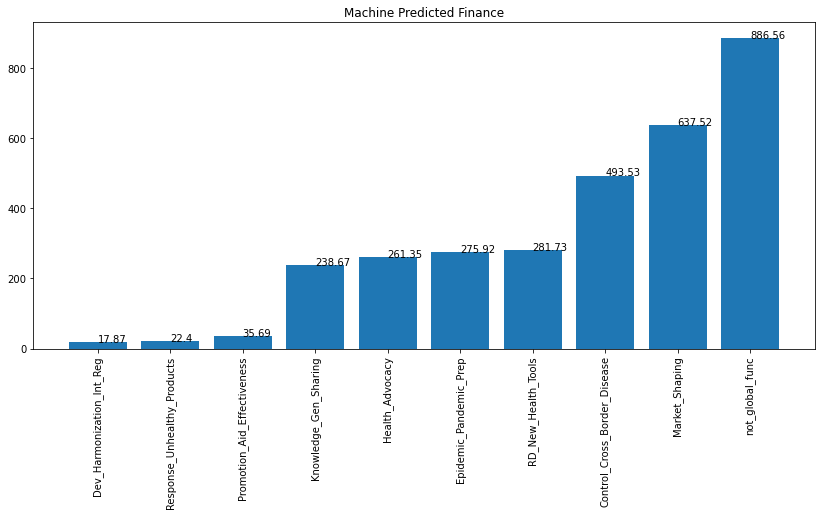

In [126]:
#plotting the distribution of categories. Creating column chart

#plotting the observation cat
plt.figure(figsize=(14,6))
plt.bar(dah_gpg_xg["class_pred"], dah_gpg_xg["Value"])
plt.xticks(rotation=90)
plt.title("Machine Predicted Finance")

for i, v in enumerate(dah_gpg_xg["Value"]):
    plt.text(i, v, str(v))

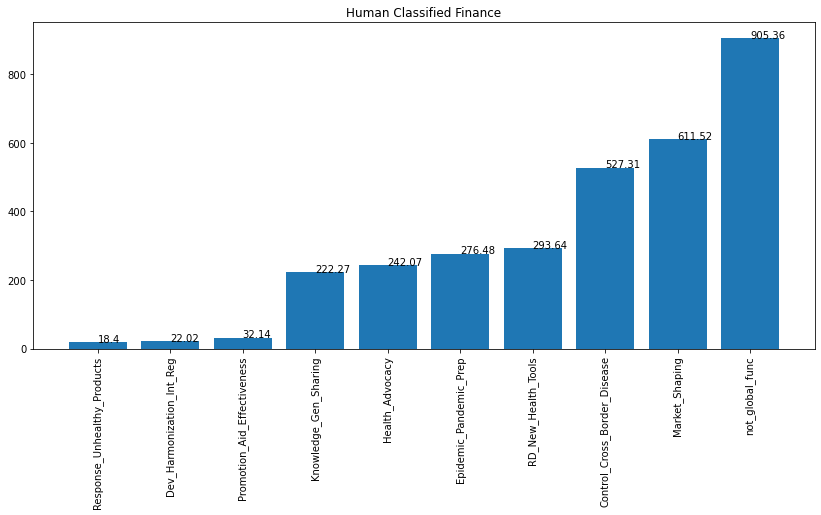

In [127]:
#actual values in different categories

dah_gpg_act_xg=test_fin_calc_xg.groupby(["label"]).agg({"Value":np.sum})

dah_gpg_act_xg=dah_gpg_act_xg.sort_values("Value").reset_index()

dah_gpg_act_xg=dah_gpg_act_xg.round(2)

#plotting the distribution of categories. Creating column chart

#plotting the observation cat
plt.figure(figsize=(14,6))
plt.bar(dah_gpg_act_xg["label"], dah_gpg_act_xg["Value"])
plt.xticks(rotation=90)
plt.title("Human Classified Finance")

for i, v in enumerate(dah_gpg_act_xg["Value"]):
    plt.text(i, v, str(v))

#### Support Vector Machine

In [147]:
svc = svm.SVC(kernel='rbf')

#fitting the model on training data
svc_model=svc.fit(x_tfidf_feat, train["label"])

In [148]:
#predicting the categories using the trained model on test set 
y_pred=svc_model.predict(x_tfidf_test_feat)

In [150]:
#printing classification results
print(classification_report(test["label"], y_pred)) 

                              precision    recall  f1-score   support

Control_Cross_Border_Disease       0.90      0.91      0.91       310
   Dev_Harmonization_Int_Reg       0.71      0.91      0.79        53
      Epidemic_Pandemic_Prep       0.94      0.80      0.86       328
             Health_Advocacy       0.87      0.89      0.88       203
       Knowledge_Gen_Sharing       0.77      0.76      0.76       585
              Market_Shaping       0.99      0.94      0.96       224
 Promotion_Aid_Effectiveness       0.83      0.42      0.56        57
         RD_New_Health_Tools       0.65      0.82      0.73       330
 Response_Unhealthy_Products       0.82      0.78      0.80        60
             not_global_func       0.78      0.78      0.78       484

                    accuracy                           0.81      2634
                   macro avg       0.83      0.80      0.80      2634
                weighted avg       0.82      0.81      0.81      2634



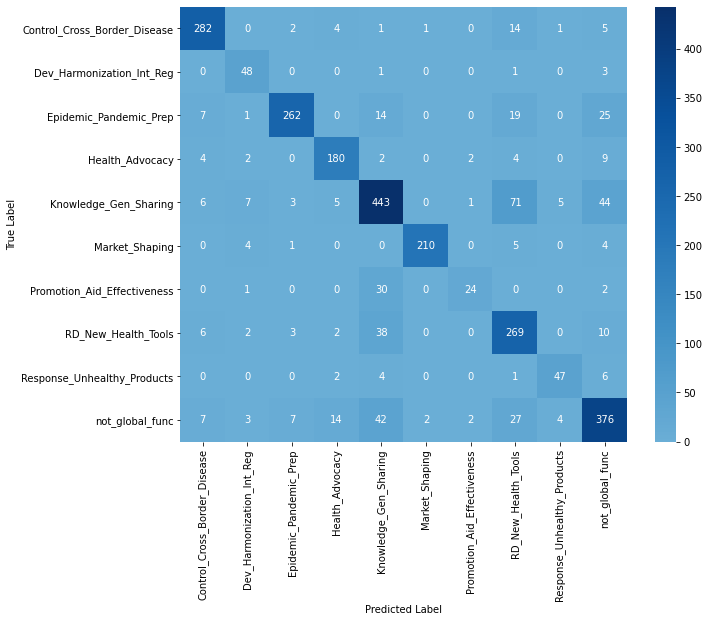

In [151]:
#heatmap of confusion matrix 
conf_mat_rf=confusion_matrix(list(test["label"]),list(y_pred))
conf_mat_df_rf= pd.DataFrame(conf_mat_rf,
                     index = np.unique(test["label"]), 
                     columns = np.unique(y_pred))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_df_rf, annot=True, cmap="Blues", center=0, fmt='g')          
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

***MultinomialNB()***

In [143]:
mnbc = MultinomialNB()

#fitting the model on training data
mnbc_model=mnbc.fit(x_tfidf_feat, train["label"])

In [144]:
#predicting the categories using the trained model on test set 
y_pred=mnbc_model.predict(x_tfidf_test_feat)

In [145]:
print(classification_report(test["label"], y_pred))

                              precision    recall  f1-score   support

Control_Cross_Border_Disease       0.86      0.84      0.85       310
   Dev_Harmonization_Int_Reg       0.66      0.89      0.76        53
      Epidemic_Pandemic_Prep       0.93      0.74      0.82       328
             Health_Advocacy       0.86      0.87      0.87       203
       Knowledge_Gen_Sharing       0.79      0.68      0.73       585
              Market_Shaping       0.99      0.88      0.93       224
 Promotion_Aid_Effectiveness       0.50      0.89      0.65        57
         RD_New_Health_Tools       0.65      0.81      0.72       330
 Response_Unhealthy_Products       0.69      0.87      0.77        60
             not_global_func       0.76      0.78      0.77       484

                    accuracy                           0.79      2634
                   macro avg       0.77      0.83      0.79      2634
                weighted avg       0.80      0.79      0.79      2634



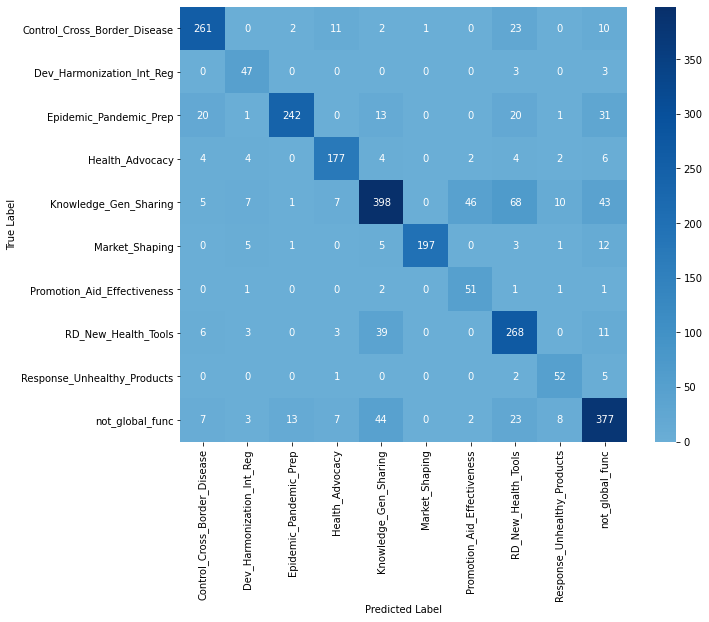

In [146]:
#heatmap of confusion matrix 
conf_mat_rf=confusion_matrix(list(test["label"]),list(y_pred))
conf_mat_df_rf= pd.DataFrame(conf_mat_rf,
                     index = np.unique(test["label"]), 
                     columns = np.unique(y_pred))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_df_rf, annot=True, cmap="Blues", center=0, fmt='g')          
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

***GaussianNB()***

In [108]:
gbnb = GaussianNB()


#fitting the model on training data
gbnb_model=gbnb.fit(x_tfidf_feat, train["label"])

In [109]:
#predicting the categories using the trained model on test set 
y_pred=gbnb_model.predict(x_tfidf_test_feat)

In [110]:
print(classification_report(test["label"], y_pred))

                              precision    recall  f1-score   support

Control_Cross_Border_Disease       0.85      0.82      0.83       282
   Dev_Harmonization_Int_Reg       0.57      0.72      0.64        47
      Epidemic_Pandemic_Prep       0.84      0.77      0.80       305
             Health_Advocacy       0.77      0.87      0.82       198
       Knowledge_Gen_Sharing       0.60      0.50      0.54       593
              Market_Shaping       0.89      0.96      0.92       225
 Promotion_Aid_Effectiveness       0.46      0.89      0.61        54
         RD_New_Health_Tools       0.54      0.70      0.61       345
 Response_Unhealthy_Products       0.77      0.65      0.71        55
             not_global_func       0.75      0.66      0.70       491

                    accuracy                           0.71      2595
                   macro avg       0.70      0.75      0.72      2595
                weighted avg       0.71      0.71      0.70      2595



***MLPclassifier()***

In [111]:
mlp = MLPClassifier(max_iter=300)

#fitting the model on training data
mlp_model=mlp.fit(x_tfidf_feat, train["label"])

In [112]:
#predicting the categories using the trained model on test set 
y_pred=mlp_model.predict(x_tfidf_test_feat)

In [113]:
print(classification_report(test["label"], y_pred))

                              precision    recall  f1-score   support

Control_Cross_Border_Disease       0.90      0.94      0.92       282
   Dev_Harmonization_Int_Reg       0.81      0.74      0.78        47
      Epidemic_Pandemic_Prep       0.91      0.89      0.90       305
             Health_Advocacy       0.91      0.88      0.90       198
       Knowledge_Gen_Sharing       0.74      0.76      0.75       593
              Market_Shaping       0.97      0.98      0.97       225
 Promotion_Aid_Effectiveness       0.83      0.28      0.42        54
         RD_New_Health_Tools       0.69      0.75      0.72       345
 Response_Unhealthy_Products       0.86      0.80      0.83        55
             not_global_func       0.80      0.80      0.80       491

                    accuracy                           0.82      2595
                   macro avg       0.84      0.78      0.80      2595
                weighted avg       0.82      0.82      0.82      2595



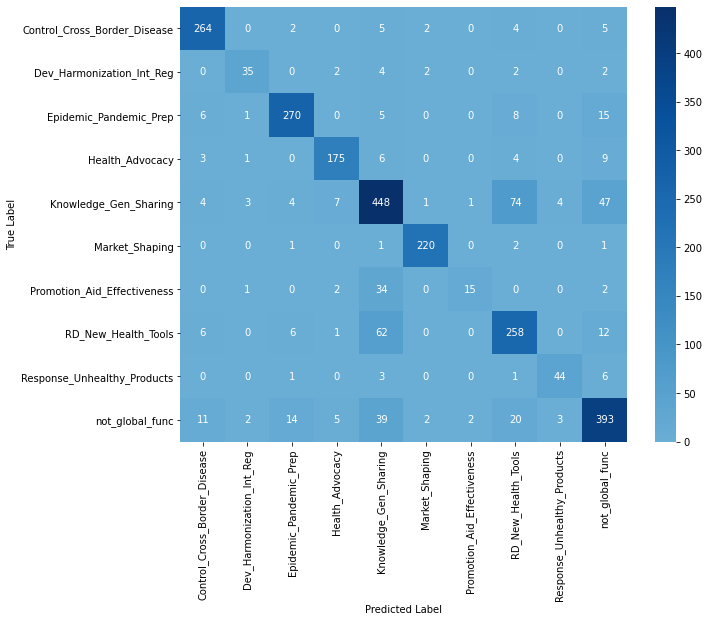

In [114]:
#heatmap of confusion matrix 
conf_mat_rf=confusion_matrix(list(test["label"]),list(y_pred))
conf_mat_df_rf= pd.DataFrame(conf_mat_rf,
                     index = np.unique(test["label"]), 
                     columns = np.unique(y_pred))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_df_rf, annot=True, cmap="Blues", center=0, fmt='g')          
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Running the model on the unseen 2019 data

In [186]:
##loading the 2019 data
crs_2019_health= pd.read_csv("crs_2019_health.csv", engine="python")

#dropping some column
crs_2019_health=crs_2019_health.drop(["Unnamed: 0"], axis=1)

crs_2019_health


,Year,DonorName,RecipientName,ProjectTitle,PurposeCode,ShortDescription,LongDescription,USD_Disbursement_Defl
0,2019,Sweden,Niger,Swedish Mission Council Humanitarian frame 201...,72010,SWEDISH MISSION COUNCIL HUMANITARIAN FRAME 201...,72010. Swedish Mission Council Humanitarian fr...,0.546554
1,2019,Sweden,"Africa, regional",Reg SRHR - Social marketing of reproductive he...,13020,REG SRHR - SOCIAL MARKETING OF REPRODUCTIVE HE...,13020. Reg SRHR - Social marketing of reproduc...,3.666802
2,2019,Germany,West Bank and Gaza Strip,Support of pediatric nursing education in Qube...,12281,SUPPORT OF PEDIATRIC NURSING EDUCATION IN QUBE...,12281. Support of pediatric nursing education ...,0.252715
3,2019,World Health Organisation,Nepal,"AC_660_3.1 Reproductive, maternal, newborn, ch...",13020,"AC_660_3.1 REPRODUCTIVE, MATERNAL, NEWBORN, CH...","13020. AC_660_3.1 Reproductive, maternal, newb...",0.203367
4,2019,World Health Organisation,Djibouti,AC_274_4.2 Integrated people-centred health se...,12281,AC_274_4.2 INTEGRATED PEOPLE-CENTRED HEALTH SE...,12281. AC_274_4.2 Integrated people-centred he...,0.065166
...,...,...,...,...,...,...,...,...
2008,2019,International Development Association,Nicaragua,Health Sector Modernization Credit,12110,HEALTH SECTOR MODERNIZATION CREDIT,12110. Health Sector Modernization Credit. HEA...,0.000000
2009,2019,International Development Association,India,National AIDS Control Support Project,12110,NATIONAL AIDS CONTROL SUPPORT PROJECT,12110. National AIDS Control Support Project. ...,2.939634
2010,2019,David & Lucile Packard Foundation,Mexico,"Fundaci�n Unidos por un M�xico Vivo, A.C. Esti...",13020,"FUNDACI�N UNIDOS POR UN M�XICO VIVO, A.C. ESTI...","13020. Fundaci�n Unidos por un M�xico Vivo, A....",0.100000
2011,2019,David & Lucile Packard Foundation,Ethiopia,"Guttmacher Institute, Inc. Estimated.",13030,"GUTTMACHER INSTITUTE, INC. ESTIMATED.","13030. Guttmacher Institute, Inc. Estimated.. ...",0.265000


In [187]:
#dropping some other columns column
crs_2019_health=crs_2019_health.drop(["Year", "DonorName", "RecipientName", "ProjectTitle", "PurposeCode", "ShortDescription"], 
                                     axis=1)
crs_2019_health.head()

,LongDescription,USD_Disbursement_Defl
0,72010. Swedish Mission Council Humanitarian fr...,0.546554
1,13020. Reg SRHR - Social marketing of reproduc...,3.666802
2,12281. Support of pediatric nursing education ...,0.252715
3,"13020. AC_660_3.1 Reproductive, maternal, newb...",0.203367
4,12281. AC_274_4.2 Integrated people-centred he...,0.065166


##### Feature creation for 2019 test data

In [188]:
#Feature creation

#Creating function for calculating the length and punctuation percentage feature in the description column of data
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text)-text.count(" ")), 3)*100

#creating feature of number of sentences in the text
def count_sent(text):
    return len(nltk.sent_tokenize(text))

In [189]:
#creating features for the train dataframe
crs_2019_health["body_len"]=crs_2019_health["LongDescription"].apply(lambda x: len(x)- x.count(" "))
crs_2019_health["body_sent"]=crs_2019_health["LongDescription"].apply(lambda x: count_sent(x))
crs_2019_health["punct%"]=crs_2019_health["LongDescription"].apply(lambda x: count_punct(x))

In [190]:
crs_2019_health

,LongDescription,USD_Disbursement_Defl,body_len,body_sent,punct%
0,72010. Swedish Mission Council Humanitarian fr...,0.546554,1600,9,3.5
1,13020. Reg SRHR - Social marketing of reproduc...,3.666802,1240,5,4.1
2,12281. Support of pediatric nursing education ...,0.252715,209,4,2.9
3,"13020. AC_660_3.1 Reproductive, maternal, newb...",0.203367,193,4,9.8
4,12281. AC_274_4.2 Integrated people-centred he...,0.065166,145,4,9.0
...,...,...,...,...,...
2008,12110. Health Sector Modernization Credit. HEA...,0.000000,101,4,3.0
2009,12110. National AIDS Control Support Project. ...,2.939634,107,4,2.8
2010,"13020. Fundaci�n Unidos por un M�xico Vivo, A....",0.100000,302,6,5.3
2011,"13030. Guttmacher Institute, Inc. Estimated.. ...",0.265000,225,6,5.8


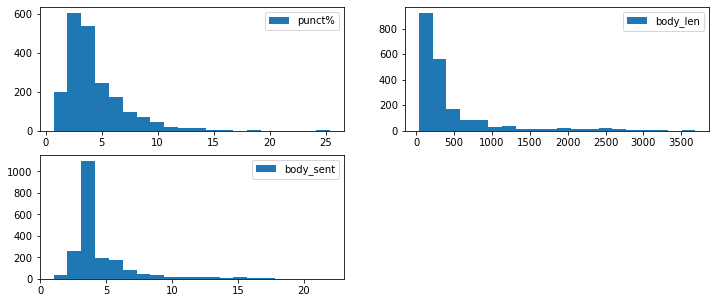

In [191]:
#lets evaluate the new features that we created and see if any of these need any transformation
plt.figure(figsize=(12,5))
plt.subplot(221)
plt.hist(crs_2019_health["punct%"], bins=20, label="punct%");
plt.legend();
plt.subplot(222)
plt.hist(crs_2019_health["body_len"], bins=20, label="body_len");
plt.legend();
plt.subplot(223)
plt.hist(crs_2019_health["body_sent"], bins=20, label="body_sent");
plt.legend();

**** We can see from the above charts that they have similar skew as the train data. So, we will use the same box-cox transformation with the same powers as used in the train data transformation

In [192]:
#applying logrithmic transformation on "body_len" column
crs_2019_health["body_len"]=crs_2019_health["body_len"].apply(lambda x: np.log10(x))

#applying logrithmic transformation on "body_len" column
crs_2019_health["body_sent"]=crs_2019_health["body_sent"].apply(lambda x: np.log10(x))

crs_2019_health["punct%"]=crs_2019_health["punct%"].apply(lambda x: x**(1/6))

crs_2019_health.head()

,LongDescription,USD_Disbursement_Defl,body_len,body_sent,punct%
0,72010. Swedish Mission Council Humanitarian fr...,0.546554,3.204120,0.954243,1.232191
1,13020. Reg SRHR - Social marketing of reproduc...,3.666802,3.093422,0.698970,1.265117
2,12281. Support of pediatric nursing education ...,0.252715,2.320146,0.602060,1.194170
3,"13020. AC_660_3.1 Reproductive, maternal, newb...",0.203367,2.285557,0.602060,1.462865
4,12281. AC_274_4.2 Integrated people-centred he...,0.065166,2.161368,0.602060,1.442250


In [193]:
#vectorizing 2019 test data
#TF-IDF--Vectorizing for raw data
x_tfidf_test_2019= tfidf_vect.transform(crs_2019_health["LongDescription"])
print(x_tfidf_test_2019.shape)


(2013, 22257)


In [194]:
#the x_tfidf_test_2019 is sparse matrix. Lets look at it in data frame form
x_tfidf_test_df2019= pd.DataFrame(x_tfidf_test_2019.toarray())

x_tfidf_test_df2019

,0,1,2,3,4,5,6,7,8,9,...,22247,22248,22249,22250,22251,22252,22253,22254,22255,22256
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [195]:
#concatenating all the features

x_tfidf_test_feat2019 = pd.concat([crs_2019_health["body_len"],crs_2019_health["body_sent"], crs_2019_health["punct%"], 
                               pd.DataFrame(x_tfidf_test_2019.toarray())], axis=1)
x_tfidf_test_feat2019.head()

,body_len,body_sent,punct%,0,1,2,3,4,5,6,...,22247,22248,22249,22250,22251,22252,22253,22254,22255,22256
0,3.204120,0.954243,1.232191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.093422,0.698970,1.265117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.320146,0.602060,1.194170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.285557,0.602060,1.462865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.161368,0.602060,1.442250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Prediction using RF model

###### load the saved RF model from disk

In [196]:
filename = 'finalized_model_rf.sav'
loaded_model_rf = pickle.load(open(filename, 'rb'))

In [197]:
#predicting the categories using the saved trained model on 2019 test set 
result2019=loaded_model_rf.predict(x_tfidf_test_feat2019)

result2019

array(['not_global_func', 'not_global_func', 'not_global_func', ...,
       'not_global_func', 'Knowledge_Gen_Sharing', 'not_global_func'],
      dtype=object)

**calculating the finance based on categories predicted** 

In [198]:
test_fin_calc2019=pd.concat([crs_2019_health, pd.DataFrame(result2019)], axis=1)

test_fin_calc2019=test_fin_calc2019.rename(columns={0:"class_pred"})

test_fin_calc2019.head()

,LongDescription,USD_Disbursement_Defl,body_len,body_sent,punct%,class_pred
0,72010. Swedish Mission Council Humanitarian fr...,0.546554,3.204120,0.954243,1.232191,not_global_func
1,13020. Reg SRHR - Social marketing of reproduc...,3.666802,3.093422,0.698970,1.265117,not_global_func
2,12281. Support of pediatric nursing education ...,0.252715,2.320146,0.602060,1.194170,not_global_func
3,"13020. AC_660_3.1 Reproductive, maternal, newb...",0.203367,2.285557,0.602060,1.462865,Control_Cross_Border_Disease
4,12281. AC_274_4.2 Integrated people-centred he...,0.065166,2.161368,0.602060,1.442250,Health_Advocacy


In [199]:
#Counting the predicted number of label in each categories 
print("not_global_func:", len(test_fin_calc2019[test_fin_calc2019["class_pred"]=="not_global_func"]))
print("Control_Cross_Border_Disease:", len(test_fin_calc2019[test_fin_calc2019["class_pred"]=="Control_Cross_Border_Disease"]))
print("Health_Advocacy:", len(test_fin_calc2019[test_fin_calc2019["class_pred"]=="Health_Advocacy"]))
print("Knowledge_Gen_Sharing:", len(test_fin_calc2019[test_fin_calc2019["class_pred"]=="Knowledge_Gen_Sharing"]))
print("Dev_Harmonization_Int_Reg:", len(test_fin_calc2019[test_fin_calc2019["class_pred"]=="Dev_Harmonization_Int_Reg"]))
print("Epidemic_Pandemic_Prep:", len(test_fin_calc2019[test_fin_calc2019["class_pred"]=="Epidemic_Pandemic_Prep"]))
print("Response_Unhealthy_Products:", len(test_fin_calc2019[test_fin_calc2019["class_pred"]=="Response_Unhealthy_Products"]))
print("Market_Shaping:", len(test_fin_calc2019[test_fin_calc2019["class_pred"]=="Market_Shaping"]))
print("RD_New_Health_Tools:", len(test_fin_calc2019[test_fin_calc2019["class_pred"]=="RD_New_Health_Tools"]))
#print("RD_Blueprint_Diseases_Pandemic_Flu:", len(test_fin_calc2019[test_fin_calc2019["class_pred"]=="RD_Blueprint_Diseases_Pandemic_Flu"]))
print("Promotion_Aid_Effectiveness:", len(test_fin_calc2019[test_fin_calc2019["class_pred"]=="Promotion_Aid_Effectiveness"]))

not_global_func: 1283
Control_Cross_Border_Disease: 139
Health_Advocacy: 217
Knowledge_Gen_Sharing: 102
Dev_Harmonization_Int_Reg: 6
Epidemic_Pandemic_Prep: 115
Response_Unhealthy_Products: 8
Market_Shaping: 27
RD_New_Health_Tools: 116
Promotion_Aid_Effectiveness: 0


In [200]:
#gpg amount based on the predicted categories
dah_gpg2019=test_fin_calc2019.groupby(["class_pred"]).agg({"USD_Disbursement_Defl":np.sum})

dah_gpg2019=dah_gpg2019.sort_values("USD_Disbursement_Defl").reset_index()

dah_gpg2019=dah_gpg2019.round(2)
dah_gpg2019

,class_pred,USD_Disbursement_Defl
0,Dev_Harmonization_Int_Reg,5.35
1,Response_Unhealthy_Products,13.56
2,Knowledge_Gen_Sharing,34.01
3,Market_Shaping,45.12
4,Epidemic_Pandemic_Prep,97.08
5,RD_New_Health_Tools,112.17
6,Control_Cross_Border_Disease,293.67
7,not_global_func,1062.22
8,Health_Advocacy,2091.06


In [201]:
#gpg finance based on predicted categories in the test dataset
dah_gpg2019[dah_gpg2019["class_pred"]!="not_global_func"].sum()

class_pred               Dev_Harmonization_Int_RegResponse_Unhealthy_Pr...
USD_Disbursement_Defl                                              2692.02
dtype: object

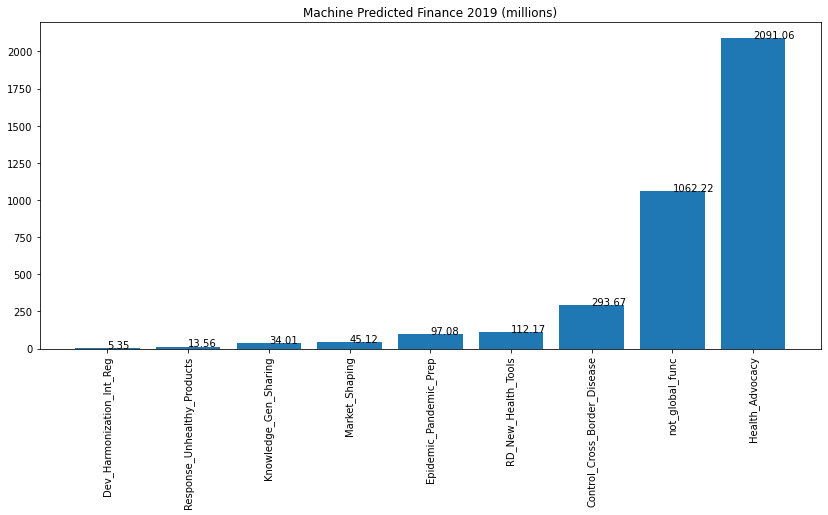

In [202]:
#plotting the distribution of categories. Creating column chart

#plotting the observation cat
plt.figure(figsize=(14,6))
plt.bar(dah_gpg2019["class_pred"], dah_gpg2019["USD_Disbursement_Defl"])
plt.xticks(rotation=90)
plt.title("Machine Predicted Finance 2019 (millions)")

for i, v in enumerate(dah_gpg2019["USD_Disbursement_Defl"]):
    plt.text(i, v, str(v))

##### Prediction using XGBoost model

###### load the saved RF model from disk

In [179]:
filename = 'finalized_model_xgboost.sav'
loaded_model_xgb = pickle.load(open(filename, 'rb'))

In [180]:
#predicting the categories using the saved trained model on 2019 test set 
result2019_xgb=loaded_model_xgb.predict(x_tfidf_test_feat2019)

result2019_xgb

array(['not_global_func', 'not_global_func', 'not_global_func', ...,
       'Health_Advocacy', 'Knowledge_Gen_Sharing', 'not_global_func'],
      dtype=object)

**calculating the finance based on categories predicted** 

In [181]:
test_fin_calc2019_xgb=pd.concat([crs_2019_health, pd.DataFrame(result2019_xgb)], axis=1)

test_fin_calc2019_xgb=test_fin_calc2019_xgb.rename(columns={0:"class_pred"})

test_fin_calc2019_xgb.head()

,LongDescription,USD_Disbursement_Defl,body_len,body_sent,punct%,class_pred
0,72010. Swedish Mission Council Humanitarian fr...,0.546554,3.204120,0.954243,1.232191,not_global_func
1,13020. Reg SRHR - Social marketing of reproduc...,3.666802,3.093422,0.698970,1.265117,not_global_func
2,12281. Support of pediatric nursing education ...,0.252715,2.320146,0.602060,1.194170,not_global_func
3,"13020. AC_660_3.1 Reproductive, maternal, newb...",0.203367,2.285557,0.602060,1.462865,Control_Cross_Border_Disease
4,12281. AC_274_4.2 Integrated people-centred he...,0.065166,2.161368,0.602060,1.442250,Health_Advocacy


In [182]:
#Counting the number of each label categories in the prediction
print("not_global_func:", len(test_fin_calc2019_xgb[test_fin_calc2019_xgb["class_pred"]=="not_global_func"]))
print("Control_Cross_Border_Disease:", len(test_fin_calc2019_xgb[test_fin_calc2019_xgb["class_pred"]=="Control_Cross_Border_Disease"]))
print("Health_Advocacy:", len(test_fin_calc2019_xgb[test_fin_calc2019_xgb["class_pred"]=="Health_Advocacy"]))
print("Knowledge_Gen_Sharing:", len(test_fin_calc2019_xgb[test_fin_calc2019_xgb["class_pred"]=="Knowledge_Gen_Sharing"]))
print("Dev_Harmonization_Int_Reg:", len(test_fin_calc2019_xgb[test_fin_calc2019_xgb["class_pred"]=="Dev_Harmonization_Int_Reg"]))
print("Epidemic_Pandemic_Prep:", len(test_fin_calc2019_xgb[test_fin_calc2019_xgb["class_pred"]=="Epidemic_Pandemic_Prep"]))
print("Response_Unhealthy_Products:", len(test_fin_calc2019_xgb[test_fin_calc2019_xgb["class_pred"]=="Response_Unhealthy_Products"]))
print("Market_Shaping:", len(test_fin_calc2019_xgb[test_fin_calc2019_xgb["class_pred"]=="Market_Shaping"]))
print("RD_New_Health_Tools:", len(test_fin_calc2019_xgb[test_fin_calc2019_xgb["class_pred"]=="RD_New_Health_Tools"]))
#print("RD_Blueprint_Diseases_Pandemic_Flu:", len(test_fin_calc2019[test_fin_calc2019["class_pred"]=="RD_Blueprint_Diseases_Pandemic_Flu"]))
print("Promotion_Aid_Effectiveness:", len(test_fin_calc2019_xgb[test_fin_calc2019_xgb["class_pred"]=="Promotion_Aid_Effectiveness"]))

not_global_func: 1370
Control_Cross_Border_Disease: 122
Health_Advocacy: 119
Knowledge_Gen_Sharing: 157
Dev_Harmonization_Int_Reg: 9
Epidemic_Pandemic_Prep: 77
Response_Unhealthy_Products: 3
Market_Shaping: 39
RD_New_Health_Tools: 116
Promotion_Aid_Effectiveness: 1


In [183]:
#CGH amount based on the predicted categories
dah_gpg2019_xgb=test_fin_calc2019_xgb.groupby(["class_pred"]).agg({"USD_Disbursement_Defl":np.sum})

dah_gpg2019_xgb=dah_gpg2019_xgb.sort_values("USD_Disbursement_Defl").reset_index()

dah_gpg2019_xgb=dah_gpg2019_xgb.round(2)
dah_gpg2019_xgb

,class_pred,USD_Disbursement_Defl
0,Response_Unhealthy_Products,0.09
1,Promotion_Aid_Effectiveness,1.51
2,Dev_Harmonization_Int_Reg,7.10
3,Epidemic_Pandemic_Prep,30.46
4,Health_Advocacy,40.08
5,Market_Shaping,48.65
6,Knowledge_Gen_Sharing,68.29
7,RD_New_Health_Tools,118.58
8,Control_Cross_Border_Disease,349.33
9,not_global_func,3090.15


In [184]:
#gpg finance based on predicted categories in the test dataset
dah_gpg2019_xgb[dah_gpg2019_xgb["class_pred"]!="not_global_func"].sum()

class_pred               Response_Unhealthy_ProductsPromotion_Aid_Effec...
USD_Disbursement_Defl                                               664.09
dtype: object

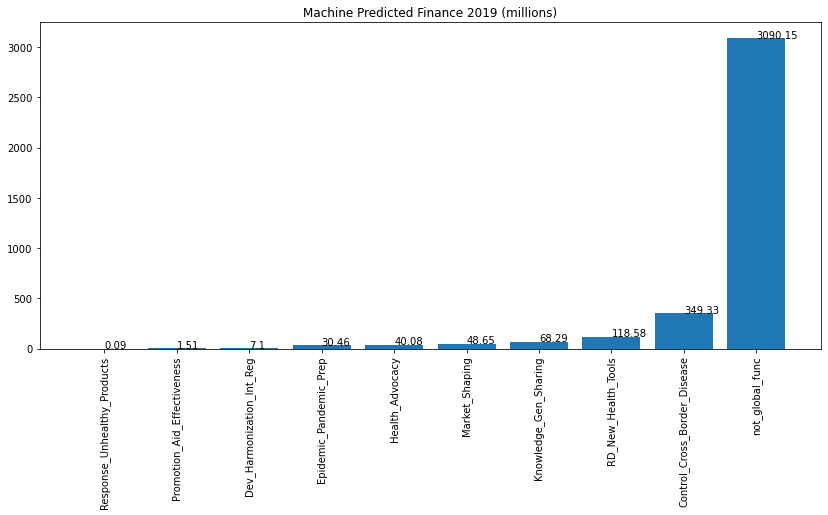

In [185]:
#plotting the distribution of categories. Creating column chart

#plotting the observation cat
plt.figure(figsize=(14,6))
plt.bar(dah_gpg2019_xgb["class_pred"], dah_gpg2019_xgb["USD_Disbursement_Defl"])
plt.xticks(rotation=90)
plt.title("Machine Predicted Finance 2019 (millions)")

for i, v in enumerate(dah_gpg2019_xgb["USD_Disbursement_Defl"]):
    plt.text(i, v, str(v))

### Running the model on the unseen 2018 data

In [ ]:
#load the saved model
loaded_model = pickle.load(open(filename, 'rb'))

In [189]:
##loading the 2019 data
crs_2018_health= pd.read_csv("crs_2018_health.csv", engine="python")

#dropping some column
crs_2018_health=crs_2018_health.drop(["Unnamed: 0"], axis=1)

crs_2018_health

,Year,DonorName,RecipientName,ProjectTitle,PurposeCode,ShortDescription,LongDescription,USD_Disbursement_Defl
0,2018,UNFPA,Nicaragua,Nicaragua - Managua. 08 - Youth leadership and...,72050,NICARAGUA - MANAGUA. 08 - YOUTH LEADERSHIP AND...,72050. Nicaragua - Managua. 08 - Youth leaders...,0.022965
1,2018,UNFPA,Mexico,Mexico - Mexico City. 01 - SRH Policies,13010,MEXICO - MEXICO CITY. 01 - SRH POLICIES,13010. Mexico - Mexico City. 01 - SRH Policies...,0.023190
2,2018,UNFPA,Cuba,Cuba - Havana. 14 - Demographic intelligence,13010,CUBA - HAVANA. 14 - DEMOGRAPHIC INTELLIGENCE,13010. Cuba - Havana. 14 - Demographic intelli...,0.006837
3,2018,UNFPA,Tanzania,Tanzania - Dar-es-Salaam. 03 - Health workforc...,13081,TANZANIA - DAR-ES-SALAAM. 03 - HEALTH WORKFORC...,13081. Tanzania - Dar-es-Salaam. 03 - Health w...,0.006151
4,2018,UNFPA,"Bilateral, unspecified",Humanitarian Office. 11 - Prevention and addre...,72050,HUMANITARIAN OFFICE. 11 - PREVENTION AND ADDRE...,72050. Humanitarian Office. 11 - Prevention an...,0.000118
...,...,...,...,...,...,...,...,...
1999,2018,Open Society Foundations,"Caribbean, regional",UNDP Multi-Partner Trust Fund Office,12250,UNDP MULTI-PARTNER TRUST FUND OFFICE,12250. UNDP Multi-Partner Trust Fund Office. U...,0.274820
2000,2018,Open Society Foundations,"Bilateral, unspecified",International Treatment Preparedness Coalition,16064,INTERNATIONAL TREATMENT PREPAREDNESS COALITION,16064. International Treatment Preparedness Co...,0.646336
2001,2018,Open Society Foundations,"South Asia, regional",Bangladesh Legal Aid and Services Trust (BLAST),13020,BANGLADESH LEGAL AID AND SERVICES TRUST (BLAST),13020. Bangladesh Legal Aid and Services Trust...,0.305355
2002,2018,Japan,Tanzania,TC AGGREGATED ACTIVITIES,12110,TC AGGREGATED ACTIVITIES,12110. TC AGGREGATED ACTIVITIES. TC AGGREGATED...,0.373384


In [190]:
#dropping some other columns column
crs_2018_health=crs_2018_health.drop(["Year", "DonorName", "RecipientName", "ProjectTitle", "PurposeCode", "ShortDescription"], 
                                     axis=1)
crs_2018_health.head()

,LongDescription,USD_Disbursement_Defl
0,72050. Nicaragua - Managua. 08 - Youth leaders...,0.022965
1,13010. Mexico - Mexico City. 01 - SRH Policies...,0.023190
2,13010. Cuba - Havana. 14 - Demographic intelli...,0.006837
3,13081. Tanzania - Dar-es-Salaam. 03 - Health w...,0.006151
4,72050. Humanitarian Office. 11 - Prevention an...,0.000118


#### Feature creation for 2018 test data

In [191]:
#creating features for the train dataframe
crs_2018_health["body_len"]=crs_2018_health["LongDescription"].apply(lambda x: len(x)- x.count(" "))
crs_2018_health["body_sent"]=crs_2018_health["LongDescription"].apply(lambda x: count_sent(x))
crs_2018_health["punct%"]=crs_2018_health["LongDescription"].apply(lambda x: count_punct(x))

In [192]:
crs_2018_health

,LongDescription,USD_Disbursement_Defl,body_len,body_sent,punct%
0,72050. Nicaragua - Managua. 08 - Youth leaders...,0.022965,158,6,6.3
1,13010. Mexico - Mexico City. 01 - SRH Policies...,0.023190,115,6,7.8
2,13010. Cuba - Havana. 14 - Demographic intelli...,0.006837,127,6,7.1
3,13081. Tanzania - Dar-es-Salaam. 03 - Health w...,0.006151,144,6,9.0
4,72050. Humanitarian Office. 11 - Prevention an...,0.000118,154,6,5.2
...,...,...,...,...,...
1999,12250. UNDP Multi-Partner Trust Fund Office. U...,0.274820,214,6,5.6
2000,16064. International Treatment Preparedness Co...,0.646336,366,5,2.7
2001,13020. Bangladesh Legal Aid and Services Trust...,0.305355,791,8,3.5
2002,12110. TC AGGREGATED ACTIVITIES. TC AGGREGATED...,0.373384,74,4,4.1


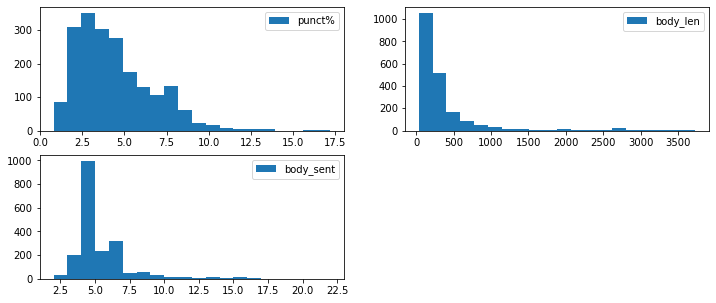

In [193]:
#lets evaluate the new features that we created and see if any of these need any transformation
plt.figure(figsize=(12,5))
plt.subplot(221)
plt.hist(crs_2018_health["punct%"], bins=20, label="punct%");
plt.legend();
plt.subplot(222)
plt.hist(crs_2018_health["body_len"], bins=20, label="body_len");
plt.legend();
plt.subplot(223)
plt.hist(crs_2018_health["body_sent"], bins=20, label="body_sent");
plt.legend();

**** We can see from the above charts that they have similar skew as the train data. So, we will use the same box-cox transformation with the same powers as used in the train data transformation


In [194]:
#applying logrithmic transformation on "body_len" column
crs_2018_health["body_len"]=crs_2018_health["body_len"].apply(lambda x: np.log10(x))

#applying logrithmic transformation on "body_len" column
crs_2018_health["body_sent"]=crs_2018_health["body_sent"].apply(lambda x: np.log10(x))

crs_2018_health["punct%"]=crs_2018_health["punct%"].apply(lambda x: x**(1/6))

crs_2018_health.head()

,LongDescription,USD_Disbursement_Defl,body_len,body_sent,punct%
0,72050. Nicaragua - Managua. 08 - Youth leaders...,0.022965,2.198657,0.778151,1.359012
1,13010. Mexico - Mexico City. 01 - SRH Policies...,0.023190,2.060698,0.778151,1.408259
2,13010. Cuba - Havana. 14 - Demographic intelli...,0.006837,2.103804,0.778151,1.386361
3,13081. Tanzania - Dar-es-Salaam. 03 - Health w...,0.006151,2.158362,0.778151,1.442250
4,72050. Humanitarian Office. 11 - Prevention an...,0.000118,2.187521,0.778151,1.316236


In [195]:
#vectorizing 2018 test data
#TF-IDF--Vectorizing for train data

x_tfidf_test_2018= tfidf_vect.transform(crs_2018_health["LongDescription"])
print(x_tfidf_test_2018.shape)

(2004, 22342)


In [196]:
#the x_tfidf_test_2018 is sparse matrix. Lets look at it in data frame form
x_tfidf_test_df2018= pd.DataFrame(x_tfidf_test_2018.toarray())

x_tfidf_test_df2018

,0,1,2,3,4,5,6,7,8,9,...,22332,22333,22334,22335,22336,22337,22338,22339,22340,22341
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [197]:
#concatenating all  the features

x_tfidf_test_feat2018 = pd.concat([crs_2018_health["body_len"],crs_2018_health["body_sent"], crs_2018_health["punct%"], 
                               pd.DataFrame(x_tfidf_test_2018.toarray())], axis=1)
x_tfidf_test_feat2018.head()

,body_len,body_sent,punct%,0,1,2,3,4,5,6,...,22332,22333,22334,22335,22336,22337,22338,22339,22340,22341
0,2.198657,0.778151,1.359012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.060698,0.778151,1.408259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.103804,0.778151,1.386361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.158362,0.778151,1.442250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.187521,0.778151,1.316236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [198]:
#predicting the categories using the saved trained model on 2019 test set 
result2018=loaded_model.predict(x_tfidf_test_feat2018)

result2018

array(['not_global_func', 'Health_Advocacy', 'Health_Advocacy', ...,
       'not_global_func', 'not_global_func', 'Epidemic_Pandemic_Prep'],
      dtype=object)

**calculating the finance for 2018 based on categories predicted** 

In [199]:
test_fin_calc2018=pd.concat([crs_2018_health, pd.DataFrame(result2018)], axis=1)

test_fin_calc2018=test_fin_calc2018.rename(columns={0:"class_pred"})

test_fin_calc2018.head()

,LongDescription,USD_Disbursement_Defl,body_len,body_sent,punct%,class_pred
0,72050. Nicaragua - Managua. 08 - Youth leaders...,0.022965,2.198657,0.778151,1.359012,not_global_func
1,13010. Mexico - Mexico City. 01 - SRH Policies...,0.023190,2.060698,0.778151,1.408259,Health_Advocacy
2,13010. Cuba - Havana. 14 - Demographic intelli...,0.006837,2.103804,0.778151,1.386361,Health_Advocacy
3,13081. Tanzania - Dar-es-Salaam. 03 - Health w...,0.006151,2.158362,0.778151,1.442250,not_global_func
4,72050. Humanitarian Office. 11 - Prevention an...,0.000118,2.187521,0.778151,1.316236,not_global_func


In [200]:
#gpg amount based on the predicted categories
dah_gpg2018=test_fin_calc2018.groupby(["class_pred"]).agg({"USD_Disbursement_Defl":np.sum})

dah_gpg2018=dah_gpg2018.sort_values("USD_Disbursement_Defl").reset_index()

dah_gpg2018=dah_gpg2018.round(2)
dah_gpg2018

,class_pred,USD_Disbursement_Defl
0,Response_Unhealthy_Products,0.06
1,Promotion_Aid_Effectiveness,2.11
2,Dev_Harmonization_Int_Reg,2.18
3,Knowledge_Gen_Sharing,11.99
4,Market_Shaping,20.54
5,Health_Advocacy,49.78
6,RD_New_Health_Tools,90.00
7,Epidemic_Pandemic_Prep,99.37
8,Control_Cross_Border_Disease,151.24
9,not_global_func,1143.42


In [201]:
#gpg finance based on predicted categories in the test dataset
dah_gpg2018[dah_gpg2018["class_pred"]!="not_global_func"].sum()

class_pred               Response_Unhealthy_ProductsPromotion_Aid_Effec...
USD_Disbursement_Defl                                               427.27
dtype: object

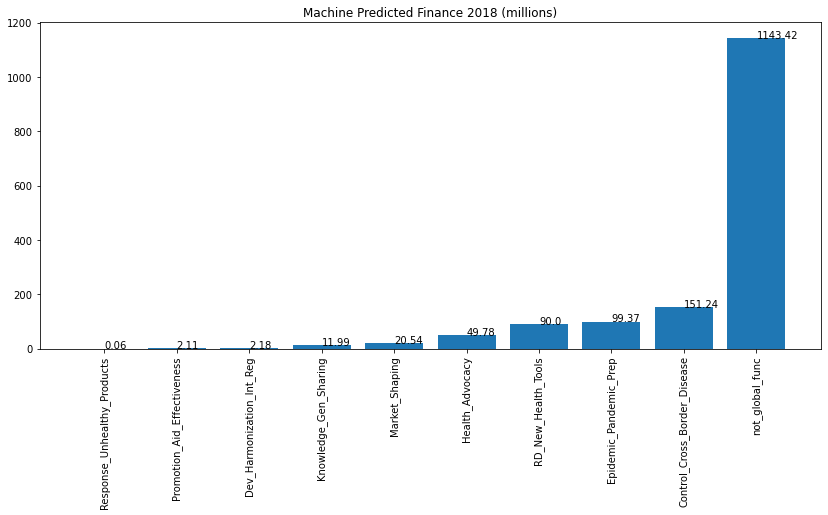

In [204]:
#plotting the distribution of categories. Creating column chart

#plotting the observation cat
plt.figure(figsize=(14,6))
plt.bar(dah_gpg2018["class_pred"], dah_gpg2018["USD_Disbursement_Defl"])
plt.xticks(rotation=90)
plt.title("Machine Predicted Finance 2018 (millions)")

for i, v in enumerate(dah_gpg2018["USD_Disbursement_Defl"]):
    plt.text(i, v, str(v))